<a href="https://colab.research.google.com/github/amuradbegovic/rang-lista-svjetskih-univerziteta-vis/blob/main/VIS25-Z2-TIM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zadaća 2 - Statistička analiza svjetskih univerziteta

Tim 1: **Adnan Muradbegović, Aid Mustafić, Tarik Redžić, Zlatan Ljutika**

---

Teško je pronaći opću mjeru kvalitete za visokoobrazovne institucije, s tim da se većina univerziteta širom svijeta bavi mnogim različitim oblastima, kao što su nastava, istraživanje i razmjena znanja. 
Ipak, odlučiti se za način predviđanja ukupne kvalitete institucije bilo bi poželjno za one koji žele donijeti informisanu odluku o tome da li da se angažuju s određenim univerzitetom, bilo kao student, istraživač ili partner iz industrije.

U ovom projektu, izvršavamo statističku analizu _[Times Higher Education](https://www.timeshighereducation.com)_ rang liste svjetskih univerziteta za 2024. godinu.

Izvor podataka: <br>
**[Dosad, D. (2024), Times World University Rankings 2024](https://www.kaggle.com/datasets/ddosad/timesworlduniversityrankings2024)**

***Vrlo je nužno pokrenuti sljedeći blok koda.***



In [ ]:
# Učitavanje nužnih biblioteka i inicijalizacija seta podataka za rad
!curl -LJO https://raw.githubusercontent.com/amuradbegovic/rang-lista-svjetskih-univerziteta-vis/main/TIMES_WorldUniversityRankings_2024.csv
!pip install -r https://raw.githubusercontent.com/amuradbegovic/rang-lista-svjetskih-univerziteta-vis/main/requirements.txt # Preporučeno isključivo pri prvom pokretanju.

import pandas as pd                   ## Za manipulisanje golih podataka, (CSV, DataFrame,...)
import matplotlib.pyplot as plt       ## Za vizualizaciju podataka
import seaborn as sns                 ## Za vizualizaciju podat
import numpy as np                    ## Za izvršavanje matematičkih operacija nad podacima
from numpy import cov
from IPython.display import HTML    ## Za kreiranje tabela i HTML manipulaciju
from IPython.display import Markdown
# Dodatni
import statistics
import pycountry_convert as pc
import plotly.express as px
import plotly.io as pio
import scipy.stats as stats
from scipy.stats import ttest_ind
import matplotlib.ticker as mtick
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.weightstats import ztest
from collections import Counter


df = pd.read_csv("TIMES_WorldUniversityRankings_2024.csv")

# Nužni koraci, postoje greške u notaciji polja i tipovima podataka u datasetu.
# Procent intl. studenta je sada 0.X, umjesto X%
# Proporcija ženskih-muških studenata je sada 0.X, umjesto 'X : Y'
# N/A podaci su zapisani kao 0
df['stats_number_students'] = df['stats_number_students'].str.replace(',', '').astype(float) 
fill_values = {
    'int64': 0,
    'float64': 0.0,
    'object': '0',      
    'bool': False
}

for col in df.columns:
    dtype_name = df[col].dtype.name
    fill_value = fill_values.get(dtype_name, None)
    if fill_value is not None and df[col].isna().any():
        was_na = df[col].isna()
        df[col] = df[col].fillna(fill_value)
        df[col+'_imputed']= was_na # Ubačen flag da li je ubačena vrijednost ili ne. (Bool: da li je ubačena?)

mask = df['stats_pc_intl_students'].str.match(r'^\d+(\.\d+)?%$')
df.loc[~mask, 'stats_pc_intl_students'] = '0%'
df['stats_pc_intl_students'] = df['stats_pc_intl_students'].str.rstrip('%')
df['stats_pc_intl_students'] = (df['stats_pc_intl_students'].astype(float) / 100)
df['stats_female_male_ratio'] = df['stats_female_male_ratio'].astype(str).str.replace(' ','',regex=False)

mask = df['stats_female_male_ratio'].str.match(r'^\d+\s*:\s*\d+$')
df.loc[~mask,'stats_female_male_ratio'] = '0'
female_ratio = df.loc[mask, 'stats_female_male_ratio'].str.replace(' ', '', regex=False).str.split(':')
female_ratio = female_ratio.apply(lambda x: int(x[0]) / (int(x[0]) + int(x[1])))
df.loc[mask, 'stats_female_male_ratio'] = female_ratio
df['stats_female_male_ratio'] = df['stats_female_male_ratio'].astype(float)

# Prostor za višekorisne varijable
# --------------------------------
major_scores = [
    'scores_teaching',
    'scores_research',
    'scores_citations',
    'scores_industry_income',
    'scores_international_outlook'
]
df_ranked = df[df['scores_overall_rank'] < 1_000_000].copy()

def get_continent(country_name):
    country_mapping = {
        'USA': 'United States',
        'US': 'United States',
        'UK': 'United Kingdom',
        'UAE': 'United Arab Emirates',
        'Hong Kong': 'China',
        'Macau': 'China',
        'Republic of Ireland': 'Ireland',
        'Russian Federation': 'Russia',
        'Taiwan': 'China',
        'Palestine, State of': 'Palestine',
        'Kosovo': 'Serbia'
    }
    
    standardized_name = country_mapping.get(country_name, country_name)
    
    try:
        country_code = pc.country_name_to_country_alpha2(standardized_name)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        return pc.convert_continent_code_to_continent_name(continent_code)
    except:
        try:
            for suffix in [' of', ' the', ' and']:
                if suffix in standardized_name:
                    standardized_name = standardized_name.split(suffix)[0]
                    break
            country_code = pc.country_name_to_country_alpha2(standardized_name)
            continent_code = pc.country_alpha2_to_continent_code(country_code)
            return pc.convert_continent_code_to_continent_name(continent_code)
        except:
            print(f"Could not map country: {country_name}")
            return 'Unknown'

continent_data = df['location'].apply(get_continent)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1831k  100 1831k    0     0  3050k      0 --:--:-- --:--:-- --:--:-- 3052k
ERROR: Invalid requirement: '#'

[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


_**Napomena:**  Za potrebe ove zadaće, set podataka iz različitih okolnosti smo prinuđeni prilagoditi._  
**Ključne razlike** uključuju:  
* **Izvršen _data-cleaning_** metodom postavljanja N/A na 0 u odgovarajućem formatu. _(Naročito zbog inkluzije _'Reporter'_ ranga, više o tom poslije.)_  
Prethodno smo pokušali primjeniti metodu postavljanja na srednju vrijednost distribucije kolone, ali se ispostavilo da bi to uveliko utjecalo na iste.
* Ubacivanje kolona tipa bool: ***"Da li je umetnuta vrijednost 0 ili je već tu?"***
* **Formatiranje i pretvaranje pojedinih kolona** za višu i optimalniju upotrebu.

### 1. Deskriptivna statistika i vizualizacija distribucija podataka

Član tima: **Tarik Redžić**

---

 _THE (Times Higher Education) rang lista svjetskih univerziteta 2024. godine_ rangira ukupno **1904 univerziteta** iz 108 zemalja i regija.  
 U ovom poglavlju nastojimo prvenstveno opisati i upoznati se sa metodologijom rangiranja, načinom obrade podataka u ovom setu te korištenim parametrima.
 _U nastavku, važna je napomena da opis seta podataka i rang liste analogno važe jedno za drugo._

_Jedna zanimljivost, koju ćemo posebno razmatrati, je da je ovo **prvi put da se Univerzitet u Sarajevu ili uopšte jedna visokoobrazovna institucija iz Bosne i Hercegovine pojavi na ovoj rang listi**, što je čak istaknuto na službenoj web-stranici rang liste:_ 
> ,,Four countries enter the ranking for the first time – all of them in Europe. The addition of Kosovo, Bosnia and Herzegovina, North Macedonia and Armenia..."



##### **Metodologija i parametri**  
> ,,The table is based on our new WUR 3.0 methodology, which includes 18 carefully calibrated performance indicators that measure an institution’s performance across five areas: teaching, research environment, research quality, industry, and international outlook."  
  \- Times Higher Education
  


  _Set podataka se sastoji od:_  
* **Broj redova (univerziteta): _2673_**
    
    Pored 1904 rangiranih univerziteta, ***postoje 769 sa 'Reporter' statusom,*** tj. univerziteti koji su proslijedili podatke ali nisu zadovoljavali kriterij za rank, ali su prihvatili da budu prikazani kao "reporteri" u konačnoj tabeli.  
    *(Primjer, na jednoj rang listi, sa Reporter statusom se nalazi "University of Mostar", da li to bio UNMO/Džemal Bijedić ili SUM/Sveučilište u Mostaru, nije poznato, te se ne broji kao visokoobrazovna ustanova uvrštena u ovu rang listu)*

* **Broj kolona: _29, od kojih je 17 parametara pokazatelja učinka iz metodologije._**

   ***Parametri su grupisani na sljedeći način:***  
     * Teaching _(bos. **'Nastava'**, u datasetu: **'scores_teaching'**)_
        * Teaching Reputation _(bos. **'Reputacija nastave'**)_
        * Student Staff Ratio _(bos. **Proporcija Student-Osoblje,** u datasetu: **'stats_student_staff_ratio'**)_
        * Doctorate Bachelor Ratio _(bos. **Proporcija Doktorat-Bakalaureat,**)_
        * Doctorate Staff Ratio _(bos. **Proporcija Doktorat-Osoblje,**)_
        * Institutional Income _(bos. **Prihod institucije,**)_
    * Research _(bos. **'Istraživanje**, u dataset **'scores_research'**)
        * Research Environment _(bos. **Istraživačko okruženje**)_
          * Research Reputation _(bos. '**Istraživačka reputacija**)_
          * Research Income _(bos. **Prihodi od istraživanja,**)_
          * Research Productivity _(bos. **Produktivnost u istraživanju,**)_
        * Research Quality _(bos. **Kvaliteta istraživanja,**)_
          * Citation Impact _(bos. **Uticaj pri citiranju,** u datasetu: **'scores_citation'**)_
          * Research Strength _(bos. **Istraživačka snaga,**)_
          * Research Excellence _(bos. **Kvaliteta istraživanja,**)_
          * Research Influence _(bos. **Istraživački uticaj,**)_
    * International outlook _(bos. **'Međunarodni povezanost'**, u datasetu: **'scores_international_outlook'**)_
        * International Students _(bos. **Međunarodni studenti,** u datasetu: **'stats_pc_intl_students'**)_
        * International Staff _(bos. **Međunarodno osoblje**)_
        * International Co-authorship _(bos. **Međunarodno koautorstvo**)_
    * Industry
        * Industry Income _(bos. **Prihodi od industrije,** u datasetu: **'scores_industry_income'**)_
        * Patents _(bos. **Patenti**)_


_**Napomena:** Većina kriterija je korišteno u svrhe samog rangiranja, kao pomoćni za odgovorajući sveobuhvatni rezultat, koje je autor dataseta adekvatno svrstao i suzio za potrebe statističke analize. Više informacija o WUR metodologiji možete pronaći [ovdje.](https://www.timeshighereducation.com/sites/default/files/the_2024_world_university_rankings_methodology.pdf)_


In [2]:
###@title **Tabela 1: Primjer zapisa u setu podataka"** { display-mode: "form" }
display(df[df['scores_overall_rank'] == 18290])
display(Markdown('Tabela 1: Primjer zapisa u setu podataka'))

,rank,name,scores_overall,scores_overall_rank,scores_teaching,scores_teaching_rank,scores_research,scores_research_rank,scores_citations,scores_citations_rank,...,website_url,scores_overall_imputed,scores_teaching_imputed,scores_research_imputed,scores_citations_imputed,scores_industry_income_imputed,scores_international_outlook_imputed,stats_female_male_ratio_imputed,subjects_offered_imputed,website_url_imputed
1828,1501+,University of Sarajevo,9.7–22.7,18290,16.4,1673,10.8,1552,18.6,1707,...,0,False,False,False,False,False,False,False,False,True


Tabela 1: Primjer zapisa u setu podataka

In [3]:
df_display = df[['scores_overall_rank','scores_teaching','scores_research','scores_citations','scores_international_outlook','stats_number_students','scores_industry_income','stats_pc_intl_students','stats_female_male_ratio']]
pd.set_option('display.float_format', '{:.2f}'.format)
print("Tabela 2: Osnovne mjere varijacije i centralne težnje za odabrane numeričke parametre") 
df_display.describe()


Tabela 2: Osnovne mjere varijacije i centralne težnje za odabrane numeričke parametre


,scores_overall_rank,scores_teaching,scores_research,scores_citations,scores_international_outlook,stats_number_students,scores_industry_income,stats_pc_intl_students,stats_female_male_ratio
count,2673.00,2673.00,2673.00,2673.00,2673.00,2673.00,2673.00,2673.00,2673.00
mean,294587.23,20.70,16.68,37.18,35.55,18357.77,33.52,0.10,0.49
std,448657.02,17.67,17.63,31.72,29.15,23325.31,30.68,0.13,0.17
min,10.00,0.00,0.00,0.00,0.00,25.00,0.00,0.00,0.00
25%,6690.00,0.00,0.00,0.00,0.00,6175.00,0.00,0.01,0.42
50%,13370.00,20.50,12.70,34.50,34.50,12771.00,25.00,0.05,0.53
75%,1000101.00,30.40,23.50,65.40,55.30,23951.00,58.40,0.13,0.59
max,1000769.00,99.00,100.00,99.70,98.80,482541.00,100.00,1.00,1.00


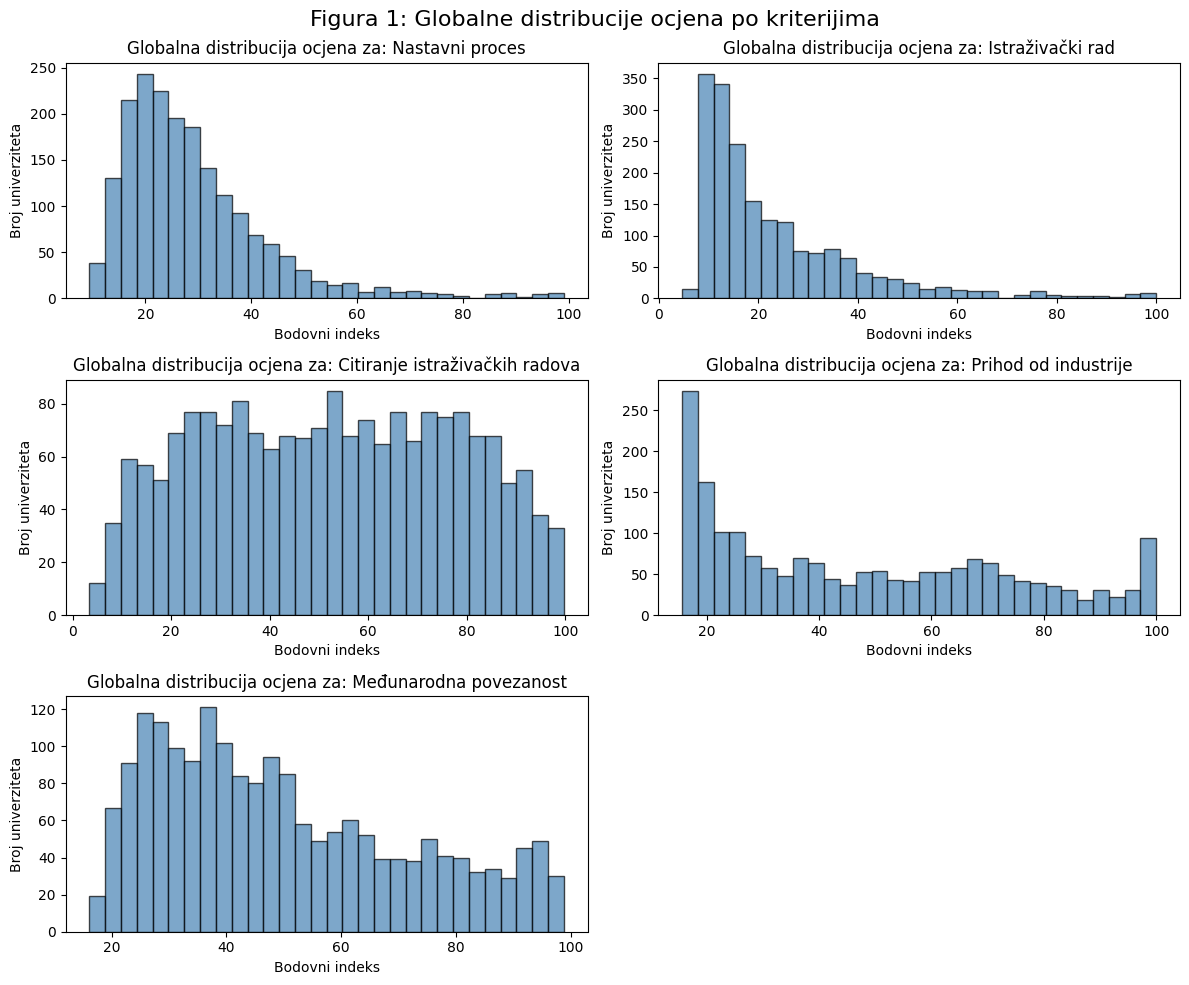

In [4]:
###@title **Figura 1: Globalne distribucije ocjena po kriterijima** { display-mode: "form" }
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(major_scores):
    data = df[col][df[col] > 0]
    axes[i].hist(data, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    match i:
        case 0:
            title = f"Nastavni proces"
        case 1:
            title = f"Istraživački rad"
        case 2:
            title = f"Citiranje istraživačkih radova"
        case 3:
            title = f"Prihod od industrije"
        case 4:
            title = f"Međunarodna povezanost"


    axes[i].set_title("Globalna distribucija ocjena za: "+title)
    axes[i].set_xlabel('Bodovni indeks')
    axes[i].set_ylabel('Broj univerziteta')

if len(major_scores) < len(axes):
    fig.delaxes(axes[-1])

fig.suptitle("Figura 1: Globalne distribucije ocjena po kriterijima", fontsize=16)
plt.tight_layout()
plt.show()

Sada, imamo puno bolji uvid u realno stanje te možemo vidjeti distribucije koje jako podsjećaju na neke poznate oblike.  
Recimo, distribucija za istraživački rad jako podsjeća na gamma distribuciju, dok nastavni proces i u neku ruku i međunarodna povezanost podsjećaju na lognormalnu distribuciju.  
Dotaknuti ćemo se dodatne analize nešto kasnije.

**Pogledajmo sada stanje po kontinentima.**


### 1.1 **Deskriptivna analiza univerziteta po kontinentima**
---

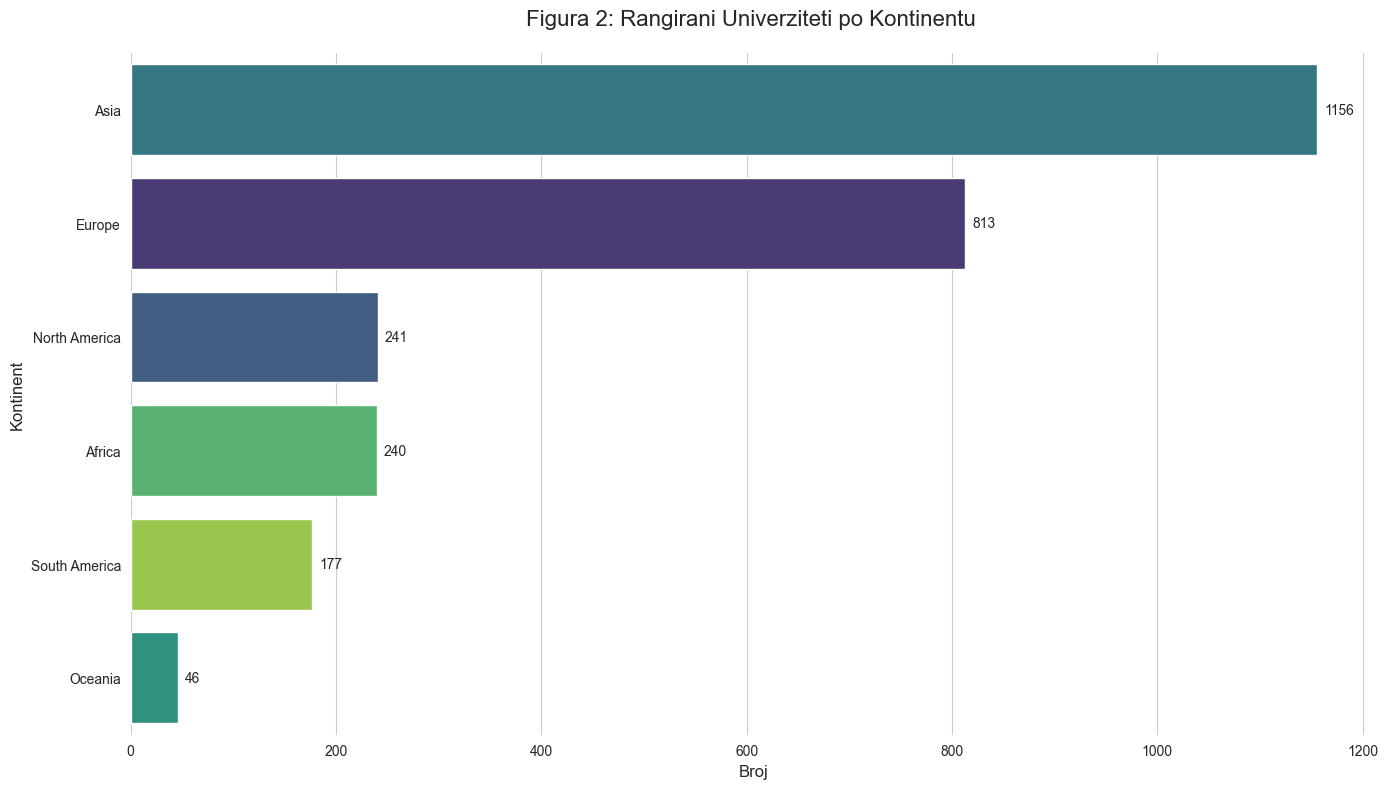

In [5]:
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
ax = sns.countplot(y=continent_data, 
                  order=continent_data.value_counts().index,
                  hue=continent_data,  
                  palette="viridis",
                  legend=False)

for p in ax.patches:
    ax.annotate(f"{int(p.get_width()):}", 
               (p.get_width(), p.get_y() + p.get_height()/2),
               ha='left', va='center', 
               xytext=(5, 0), 
               textcoords='offset points',
               fontsize=10)

plt.title("Figura 2: Rangirani Univerziteti po Kontinentu ", fontsize=16, pad=20)
plt.xlabel("Broj", fontsize=12)
plt.ylabel("Kontinent", fontsize=12)
sns.despine(left=True, bottom=True)
plt.tight_layout()

unmapped = df[continent_data == 'Unknown']['location'].unique()
if len(unmapped) > 0:
    print("\nUnmapped countries found:")
    for country in unmapped:
        print(f"- {country}")
plt.show()

***Napomena**: Prije nego što prođemo kroz ovaj histogram, vrijedi spomenuti da je inicijalno došlo do sitnih problema sa pokretanjem ovog koda.*
*Naime, bibliotečka funkcija korištena za mapiranje država u odgovarajuće kontinente podržava samo one države i teritorije koje imaju službeni ISO 3166, kod kojeg Kosovo i dalje nema (Mada neslužbeno, kod XK koriste mnoge druge međunarodne organizacije).*

*Za naše potrebe, to ne pravi problem, jer u ovom dijelu ne poredimo pojedine države, pa je bilo dovoljno instance kod kojih je polje `location` imalo vrijednost Kosovo "dodijeliti" nekoj drugoj Evropskoj državi (Logičan izbor je Srbija).*  

**Zaključak posmatranja:**  
Vidljivo je da je rang lista **ubjedljivo sačinjena od univerziteta iz Azije**, popraćeni Evropom koja također ima respektabilan broj. Nakon toga slijede Sjeverna Amerika i Afrika sa minimalnom razlikom u broju, što je dobar pokazatelj kolika je razlika u napretku obrazovnog sistema na ovim kontinentima poredeći broj država.

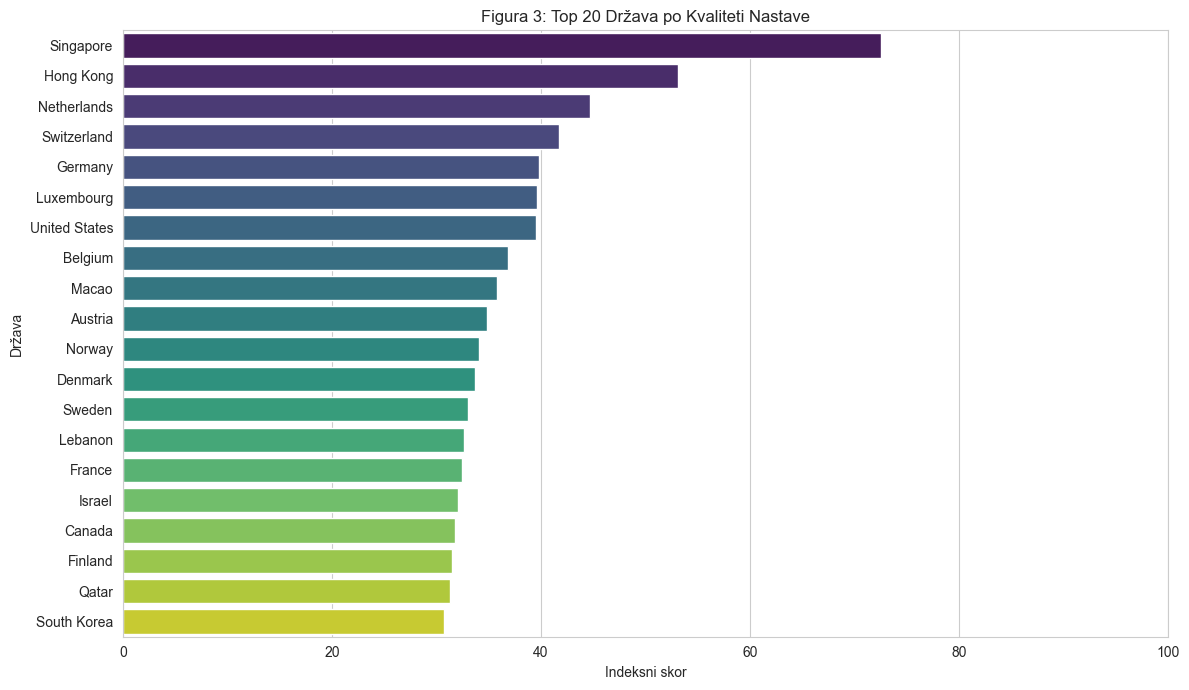

In [6]:
# Izračunaj medijan teaching score po državama (samo rangirani)
df_ranked = df[df['scores_overall_rank'] < 1_000_000].copy()
top_20_countries = (
    df_ranked.groupby('location')['scores_teaching']
    .median()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
)

plt.figure(figsize=(12, 7))
sns.barplot(
    data=top_20_countries,
    y='location',
    x='scores_teaching',
    palette='viridis',
    orient='h',
    hue='location',    # dodano da se ukloni upozorenje
    legend=False       # i da se ne prikazuje legenda
)
plt.title('Figura 3: Top 20 Država po Kvaliteti Nastave')
plt.xlabel('Indeksni skor')
plt.ylabel('Država')
plt.xlim(0, 100)
plt.tight_layout()
plt.show()


**Zaključak posmatranja:**  
Iznad se nalazi prikaz **država sa najkvalitetnijim nastavnim procesom na univerzitetima.**  
Jasno je da je **Singapur** daleko ispred ostatka svijeta, dok **Hong Kong** pokušava da parira na drugom mjestu, vidljiv je veliki jaz između njih. 

Zanimljivo je da **država poput Kine se ne nalazi u top 20 po ovom kriteriju**, dok vidimo dvije teritorije koje su prema samom Kineskom ustavu njen dio: Hong Kong, koji je ruku na srce diskutabilan, i Makau. Posmatrajmo dublje ovu zanimljivost.

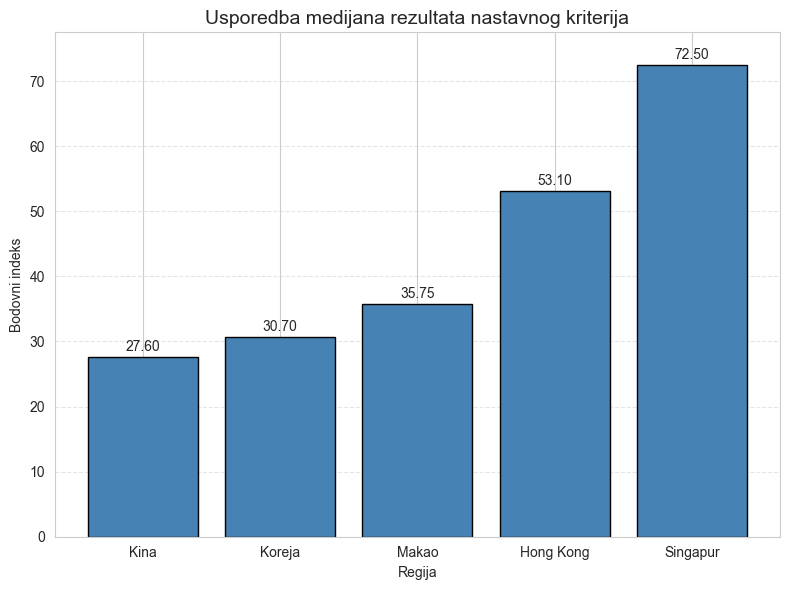

In [7]:
median_scores = {
    'Kina': df_ranked[df_ranked['location'] == 'China']['scores_teaching'].median(),
    'Koreja': df_ranked[df_ranked['location'] == 'South Korea']['scores_teaching'].median(),
    'Makao': df_ranked[df_ranked['location'] == 'Macao']['scores_teaching'].median(),
    'Hong Kong': df_ranked[df_ranked['location'] == 'Hong Kong']['scores_teaching'].median(),
    'Singapur': df_ranked[df_ranked['location'] == 'Singapore']['scores_teaching'].median()
}

# 2. Create bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(median_scores.keys(), median_scores.values(), color='steelblue', edgecolor='black')

# 3. Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

# 4. Labels and styling
plt.title("Usporedba medijana rezultata nastavnog kriterija", fontsize=14)
plt.ylabel("Bodovni indeks")
plt.xlabel("Regija")
plt.ylim(0, max(median_scores.values()) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Kina je po ovom kriteriju medijalno za tri poena iza top 20. rangirane Sjeverne Koreje,** a ubjedljivo iza prvorangiranog Singapura, međutim ako pogledamo njene najbolje univerzitete, vidjet ćemo nešto zanimljivo.

In [97]:

def prikazi_top10_markdown_tablica(df, lokacija_eng):
    mapa_lokacija = {
        'China': 'Kina',
        'Singapore': 'Singapur',
        'Macao': 'Makao',
        'Hong Kong': 'Hong Kong'
    }
    
    df_top10 = df[df['location'] == lokacija_eng].copy()
    df_top10 = df_top10.sort_values('scores_overall_rank').head(10)
    
    markdown_text = f"### Top 10 univerziteta u {mapa_lokacija[lokacija_eng]}\n\n"
    markdown_text += "| Rang | Univerzitet |\n"
    markdown_text += "|------|-------------|\n"
    for row in df_top10.itertuples():
        rank = int(row.scores_overall_rank / 10)  # dijelimo sa 10
        name = row.name
        markdown_text += f"| **{rank}** | {name} |\n"
    markdown_text += "\n"
    
    display(Markdown(markdown_text))

for grad in ['China', 'Singapore', 'Macao', 'Hong Kong']:
    prikazi_top10_markdown_tablica(df_ranked, grad)


### Top 10 univerziteta u Kina

| Rang | Univerzitet |
|------|-------------|
| **12** | Tsinghua University |
| **14** | Peking University |
| **43** | Shanghai Jiao Tong University |
| **44** | Fudan University |
| **56** | Zhejiang University |
| **57** | University of Science and Technology of China |
| **73** | Nanjing University |
| **151** | Sichuan University |
| **158** | Huazhong University of Science and Technology |
| **165** | Wuhan University |



### Top 10 univerziteta u Singapur

| Rang | Univerzitet |
|------|-------------|
| **19** | National University of Singapore |
| **32** | Nanyang Technological University, Singapore |



### Top 10 univerziteta u Makao

| Rang | Univerzitet |
|------|-------------|
| **194** | University of Macau |
| **275** | Macau University of Science and Technology |



### Top 10 univerziteta u Hong Kong

| Rang | Univerzitet |
|------|-------------|
| **35** | University of Hong Kong |
| **53** | Chinese University of Hong Kong |
| **65** | The Hong Kong University of Science and Technology |
| **82** | City University of Hong Kong |
| **88** | Hong Kong Polytechnic University |
| **319** | Hong Kong Baptist University |



**Kina ima 10 univerziteta u top 200**, što pokazuje široku zastupljenost, dok Singapur ima samo 2 univerziteta, ali oba su unutar top 35, što govori o njihovoj izuzetnoj kvaliteti. Hong Kong se ističe sa 5 univerziteta u top 100.

Makao, iako s dva univerziteta koji tek ulaze u top 200, ima bolju medijanu kvaliteta nastave od Kine. Ovo pokazuje da veličina i broj institucija nisu uvijek najbolji pokazatelj kvaliteta.

Iz ovog zaključujemo da **manje sredine poput Singapura i Makaa mogu imati koncentriraniji kvalitet**, dok **veće zemlje s više univerziteta mogu imati širi raspon kvaliteta**, što utiče na prosječne pokazatelje. Kvalitet stoga treba sagledavati dublje, a ne samo kroz kvantitet ili medijane.


**Balkanski poluotok** se također prominentno pojavljuje na ovoj rang-listi, te ćemo i njega posebno posmatrati:

In [9]:
balkanske_drzave = {
    'Albanija': 'ALB',
    'Bosna i Hercegovina': 'BIH',
    'Bugarska': 'BGR',
    'Hrvatska': 'HRV',
    'Grčka': 'GRC',
    'Crna Gora': 'MNE',
    'Sjeverna Makedonija': 'MKD',
    'Rumunija': 'ROU',
    'Srbija': 'SRB',  
    'Slovenija': 'SVN',
    'Turska': 'TUR'  
}

balkanski_podaci = df_ranked[df_ranked['location'].isin([
    'Albania', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia',
    'Greece', 'Montenegro', 'North Macedonia',
    'Romania', 'Serbia', 'Slovenia', 'Kosovo', 'Turkey'
])].copy()

balkanski_podaci['location'] = balkanski_podaci['location'].replace({
    'Kosovo': 'Serbia',
})

broj_univerziteta = balkanski_podaci['location'].value_counts().reset_index()
broj_univerziteta.columns = ['Država', 'Broj univerziteta']

prevod = {
    'Serbia': 'Srbija',
    'Montenegro': 'Crna Gora',
    'North Macedonia': 'Sjeverna Makedonija',
    'Albania': 'Albanija',
    'Bosnia and Herzegovina': 'Bosna i Hercegovina',
    'Bulgaria': 'Bugarska',
    'Croatia': 'Hrvatska',
    'Greece': 'Grčka',
    'Romania': 'Rumunija',
    'Slovenia': 'Slovenija',
    'Turkey': 'Turska'  
}

broj_univerziteta['Država'] = broj_univerziteta['Država'].map(prevod)

broj_univerziteta['ISO_kod'] = broj_univerziteta['Država'].map(balkanske_drzave)


figura = px.choropleth(
    broj_univerziteta,
    locations='ISO_kod',
    color='Broj univerziteta',
    scope='europe',
    color_continuous_scale='OrRd',
    title='<b>Balkanski poluotok: Rangirani univerziteti</b>',
    labels={'Broj univerziteta': 'Broj univerziteta'},
    hover_name='Država',
    hover_data={'ISO_kod': False}
)

figura.update_geos(
    visible=False,
    resolution=50,
    scope='world',
    center=dict(lon=22, lat=42),
    lataxis_range=[37, 47],     
    lonaxis_range=[14, 32]      
)



figura.update_layout(
    margin={"r":0,"t":40,"l":0,"b":0},
    width=900,
    height=600,
    coloraxis_colorbar=dict(
        title="Broj univerziteta",
        thickness=15,
        len=0.75
    )
)

pio.renderers.default = 'colab'  

figura.show()


Vidimo jedan zanimljiv interaktivni rangiranih visokoobrazovnih institucija sa Balkanskog poluostvra, gdje je vidljivo da **Turska dominira sa čak 75 univerziteta**, dok recimo **Albanija nema niti jednog.**  
Iako mapa prikazuje Kosovo kao nezavisnu teritoriju, zbog političke korektnosti i stava države Bosne i Hercegovine o njegovom statusu, odabrali smo da te univerzitete ne navodimo kao odvojenu cjelinu (Naravno, nije ovo jedini problem bio pri analizi i kodu, drugi je već ranije spomenut)

**Sada pogledajmo koje studijske oblasti nude najviše opcija studentima na globalnom nivou, odnosno, koji su fakulteti ili smjerovi najzastupljeniji među univerzitetima na listi.**

In [10]:


df_ranked = df[df['scores_overall_rank'] < 1_000_000].copy()

subjects_series = df_ranked['subjects_offered'].dropna()

all_subjects = []
for subj_list in subjects_series:
    subjects = [s.strip() for s in subj_list.split(',')]
    all_subjects.extend(subjects)

subject_counts = Counter(all_subjects)

subject_freq = pd.DataFrame(subject_counts.items(), columns=['Subject', 'Count'])
subject_freq = subject_freq.sort_values(by='Count', ascending=False)

fig = px.bar(
    subject_freq.head(20), 
    x='Subject',
    y='Count',
    title='Najčešće ponuđeni smjerovi na univerzitetima',
    labels={'Count': 'Broj univerziteta', 'Subject': 'Predmet'},
    text='Count'
)
fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_tickangle=45,
    height=600
)
fig.show()

Najveći broj univerziteta na listi nudi studije iz oblasti _Computer Science_ (Računarstva) i _Business & Management_ (Biznisa i menadžmenta).

**Posmatrajmo sada kako izgleda međunarodna povezanost na najprestižnijim univerzitetima na svijetu.**

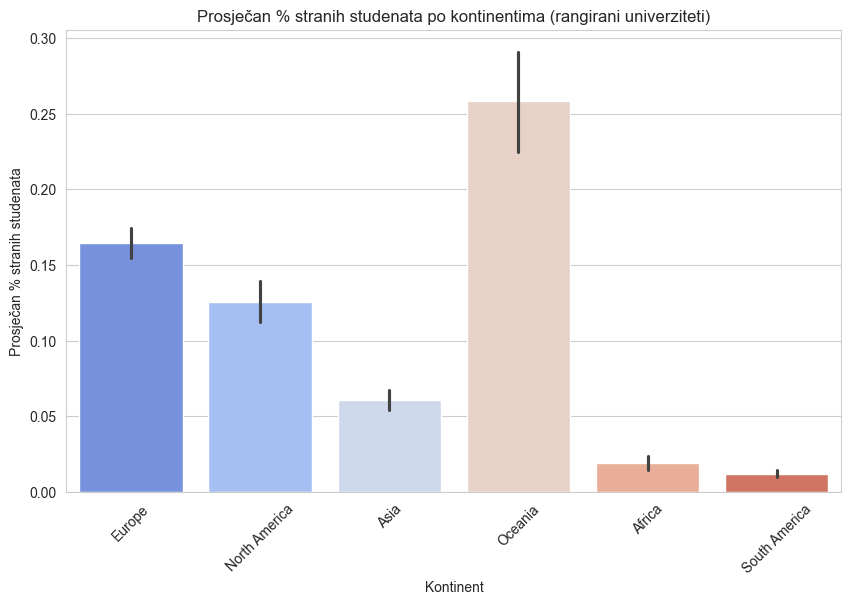

In [11]:


df_ranked['continent'] = df['location'].apply(get_continent)

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_ranked,
    x='continent',
    y='stats_pc_intl_students',
    estimator=lambda x: x.mean(),
    palette='coolwarm',
    hue='continent',    
    legend=False        
)
plt.title('Prosječan % stranih studenata po kontinentima (rangirani univerziteti)')
plt.ylabel('Prosječan % stranih studenata')
plt.xlabel('Kontinent')
plt.xticks(rotation=45)
plt.show()

**Zaključak posmatranja:** 
Konačno, imamo jednu statistiku ukorist Okeanije, postotak stranih studenata, sa nešto više od 25%.  
Možemo pretpostaviti da je glavni razlog manji broj stanovnika na ovom kontinentu u poređenju sa ostalima.  
Dalje, slijede Evropa (~16%) i Sjeverna Amerika(~13%). Azija ima tek oko 6% stranih studenata, ali tu možemo pretpostaviti da je razlog suprotan onome za Okeaniju.  
Afrika i Južna Amerika su na samom dnu liste sa oko 2% i 1% stranih studenata respektivno.

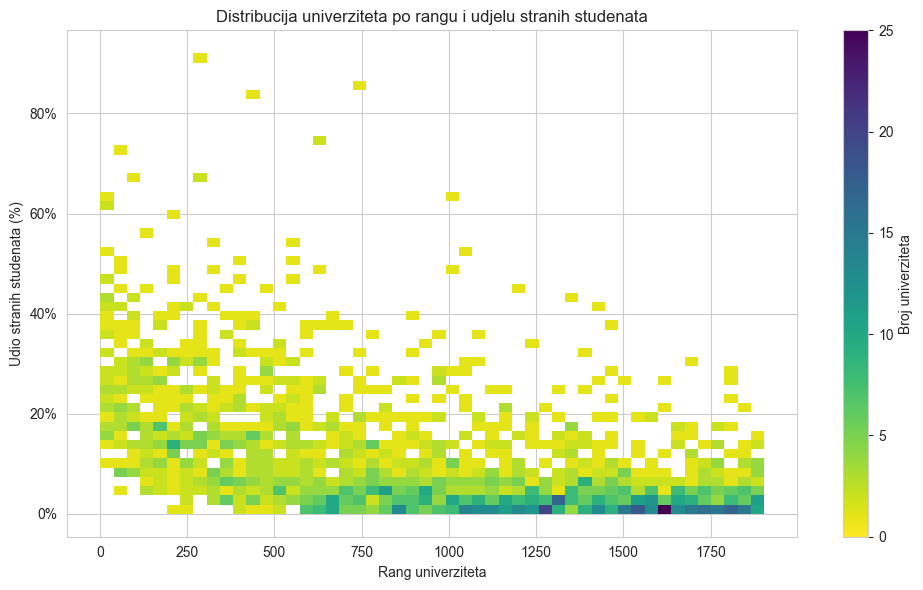

In [12]:

df_valid = df[df['scores_overall_rank'].astype(float) < 1_000_000].copy()

df_valid['stats_pc_intl_students'] = pd.to_numeric(df_valid['stats_pc_intl_students'], errors='coerce')
df_valid['scores_overall_rank'] = pd.to_numeric(df_valid['scores_overall_rank'], errors='coerce')

df_valid = df_valid.dropna(subset=['stats_pc_intl_students', 'scores_overall_rank'])

df_valid['scaled_rank'] = df_valid['scores_overall_rank'] / 10

if df_valid['stats_pc_intl_students'].max() <= 1.0:
    df_valid['stats_pc_intl_students'] *= 100

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_valid,
    x='scaled_rank',
    y='stats_pc_intl_students',
    bins=50,
    cmap='viridis_r',       
    cbar=True,
    cbar_kws={'label': 'Broj univerziteta'},
    vmin=0,                
    vmax=None              
)

plt.title('Distribucija univerziteta po rangu i udjelu stranih studenata')
plt.xlabel('Rang univerziteta')
plt.ylabel('Udio stranih studenata (%)')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
plt.tight_layout()
plt.show()

**Zaključak posmatranja:**
Ovaj heatmap poredi postotak stranih studenata na nekom univerzitetu i njegov rang na listi.  
Primjetno je da oni najbolji unverziteti imaju velik broj stranih studenata. To je razumljivo jer najbolji učenici žele na najbolje fakultete, a to nerijetko znači odlazak u drugu državu radi obrazovanja.  
Isto tako i univerziteti žele najbolje studente, tako da se često prave i dodatna mjesta isključivo za strane studente. 

Pogledajmo još jedan interesantan graf koji prikazuje koliko univerziteti dobivaju novca od privrednih subjekata, što kroz finansiranje istraživanja, što kroz ulaganje u buduće radnike, kao i nosioce same privrede u državi. 

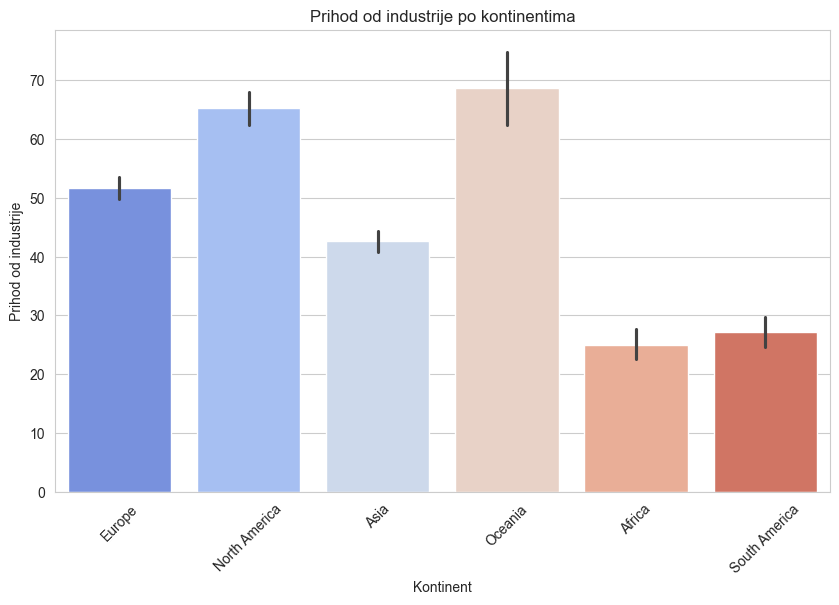

In [13]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_ranked,
    x='continent',
    y='scores_industry_income',
    estimator=lambda x: x.mean(),
    palette='coolwarm',
    hue='continent',
    legend=False
)
plt.title('Prihod od industrije po kontinentima')
plt.ylabel('Prihod od industrije')
plt.xlabel('Kontinent')
plt.xticks(rotation=45)
plt.show()


Okeanija je ponovo na vrhu liste, te sada bilježe najbolje rezultate po ovom pitanju. Sjevernoamerički univerziteti ih prate u stopu i jasno je da privreda ulaže mnogo u svoju budućnost. Slijede Evropa i Azija, i na samom dnu liste vidimo Afriku i Južnu Ameriku. S obzirom na okolnosti možda je i očekivano da vidimo ove kontinente na dnu, ali se iskreno nadamo da će se u skorijoj budućnosti to stanje popraviti.

### <p>2. <a href="https://en.wikipedia.org/wiki/Probability_distribution_fitting" style="color:inherit">Prilagođavanje distribucija vjerovatnoće podataka</a> <br> _(eng. Probability distribution fitting)_</p>

Član tima: **Aid Mustafić**

---

### 3. Provjera prilagođenih distribucija putem _[Chi-kvadratni goodness-of-fit test](https://www.geo.fu-berlin.de/en/v/soga-py/Basics-of-statistics/Hypothesis-Tests/Chi-Square-Tests/Chi-Square-Goodness-of-Fit-Test/index.html)_ i [Chi-kvadratni test nezavisnosti varijabli](https://www.pythonfordatascience.org/chi-square-test-of-independence-python/)
Član tima: **Adnan Muradbegović**

---

### 4. Provjera statističkih normalnosti - _[Kolmogorov–Smirnov, Shapiro–Wilk i QQ-plot](https://en.wikipedia.org/wiki/Normality_test)_


Član tima: **Adnan Muradbegović**

---

### 5. Estimacija intervala pouzdanosti _(eng. confidence intervals)_


Član tima: **Zlatan Ljutika**

---

U statistici, **interval pouzdanosti** je raspon vrijednosti za koje se smatra da s velikom vjerovatnoćom sadrže nepoznati parametar populacije. Analitičari često koriste nivoe pouzdanosti od 95% ili 99% prilikom izračunavanja intervala pouzdanosti. Na primjer, ako se izračuna tačna procjena iz statistički značajne populacije sa srednjom vrijednošću 10,00 i intervalom pouzdanosti od 95% koji ide od 9,5 do 10,5, to znači da postoji 95% sigurnost da prava vrijednost u populaciji zaista leži unutar tog raspona.

Statističari i drugi analitičari koriste intervale pouzdanosti kako bi procijenili da li njihova uzorkovana mjerenja, zaključci ili predviđanja odgovaraju stvarnim populacijama. Ako interval pouzdanosti sadrži vrijednost nula (ili neku drugu vrijednost iz tzv. nulte hipoteze), tada se ne može uvjerljivo tvrditi da je rezultat dobijen eksperimentom ili testiranjem posljedica nekog određenog uzroka, a ne puke slučajnosti.

Intervali pouzdanosti mjere stepen sigurnosti u vezi s metodom uzorkovanja. Najčešće se koriste nivoi pouzdanosti od **95% ili 99%**.

Mi ćemo koristiti nivo pouzdanosti od 95% u našim analizama.

Interval pouzdanosti predstavlja raspon vrijednosti, ograničen iznad i ispod srednje vrijednosti uzorka, za koji se smatra da bi vjerovatno sadržavao nepoznati parametar populacije. Nivo pouzdanosti predstavlja vjerovatnoću (odnosno postotak sigurnosti) da bi interval pouzdanosti obuhvatio stvarnu vrijednost parametra populacije kada bismo više puta uzimali nasumične uzorke iz te populacije.

U izvještaju, analitičari bi naveli nešto poput:
**"Sa 99% sigurnosti (nivo pouzdanosti) smatramo da se prava srednja vrijednost populacije nalazi između 88 i 92 (interval pouzdanosti)."**

### Upotrebe intervala pouzdanosti

Intervali pouzdanosti se izračunavaju korištenjem statističkih metoda, kao što je **t-test**. T-test je vrsta statističkog testa koji se koristi kako bi se utvrdilo postoji li značajna razlika između srednjih vrijednosti dvije grupe, koje mogu biti povezane s određenim karakteristikama. Za izračunavanje t-testa potrebna su tri ključna podatka: razlika između srednjih vrijednosti iz dva skupa podataka (tzv. srednja razlika), standardna devijacija svake grupe i broj podataka u svakoj grupi.

### $t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$

Statističari koriste intervale pouzdanosti kako bi izmjerili stepen nesigurnosti u procjeni parametra populacije na osnovu uzorka. Na primjer, istraživač može nasumično odabrati više uzoraka iz iste populacije i za svaki izračunati interval pouzdanosti, kako bi procijenio koliko dobro taj uzorak predstavlja stvarnu vrijednost varijable u populaciji. Dobijeni skupovi podataka će se međusobno razlikovati tj. neki intervali će obuhvatati stvarni parametar populacije, dok drugi neće.

### $\text{CI} = \bar{X} \pm t_{\alpha/2, \, n-1} \cdot \frac{s}{\sqrt{n}}$

U nastavku ćemo vidjeti primjere upotrebe t-testa.

Pogledajmo recimo dva kontinenta sa najviše rangiranih univerziteta: Evropu i Aziju. 
Zašto ne bismo proanalizirali recimo razliku između kvalitete odvijanja nastave na univerzitetima. T-test bi bio idealan alat da ovaj slučaj, tako da ćemo ga i iskoristiti.



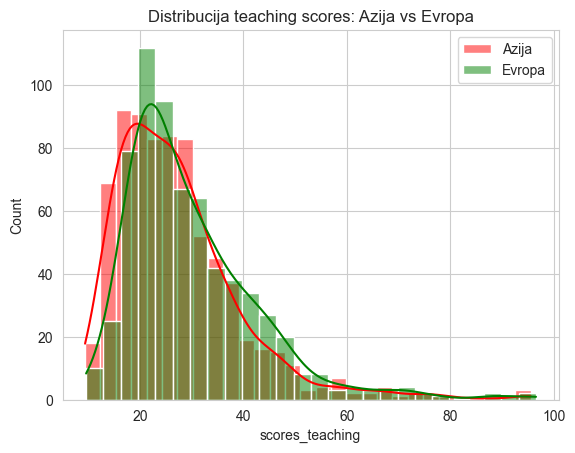

Srednja vrijednost kvaliteta nastave u Aziji: 27.24, 95% CI: (26.35, 28.12)
Srednja vrijednost kvaliteta nastave u Evropi: 29.93, 95% CI: (28.95, 30.92)

T-test resultat: t = -3.996, p = 0.0001
Statistički značajna razlika u ocjenama nastave između azijskih i evropskih univerziteta (p < 0.05)


In [14]:
continent_data = df_ranked['location'].apply(get_continent)
df_ranked = df_ranked.copy()
df_ranked['continent'] = continent_data

asia_teaching = df_ranked[df_ranked['continent'] == 'Asia']['scores_teaching'].dropna()
europe_teaching = df_ranked[df_ranked['continent'] == 'Europe']['scores_teaching'].dropna()

asia_teaching = pd.to_numeric(asia_teaching, errors='coerce').dropna()
europe_teaching = pd.to_numeric(europe_teaching, errors='coerce').dropna()

sns.histplot(asia_teaching, kde=True, label='Azija', color='red')
sns.histplot(europe_teaching, kde=True, label='Evropa', color='green')
plt.title("Distribucija teaching scores: Azija vs Evropa")
plt.xlabel("scores_teaching")
plt.legend()
plt.show()

def conf_interval(data, alpha=0.05):
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)
    h = stats.t.ppf(1 - alpha/2, n - 1) * sem
    return mean, mean - h, mean + h

mean_asia, ci_low_asia, ci_high_asia = conf_interval(asia_teaching)
mean_europe, ci_low_europe, ci_high_europe = conf_interval(europe_teaching)

print(f"Srednja vrijednost kvaliteta nastave u Aziji: {mean_asia:.2f}, 95% CI: ({ci_low_asia:.2f}, {ci_high_asia:.2f})")
print(f"Srednja vrijednost kvaliteta nastave u Evropi: {mean_europe:.2f}, 95% CI: ({ci_low_europe:.2f}, {ci_high_europe:.2f})")

t_stat, p_val = stats.ttest_ind(asia_teaching, europe_teaching, equal_var=False) #Welchov t-test
print(f"\nT-test resultat: t = {t_stat:.3f}, p = {p_val:.4f}")

if p_val < 0.05:
    print("Statistički značajna razlika u ocjenama nastave između azijskih i evropskih univerziteta (p < 0.05)")
else:
    print("Nema statistički značajne razlike u ocjenama nastave između azijskih i evropskih univerziteta (p ≥ 0.05).")


T-test daje dosta zanimljive rezultate: **nastavni proces u Evropi je u prosjeku kvalitetniji u odnosu na Aziju** i to možemo reći sa sigurnošću od 95%. Vidimo razliku u srednjim vrijednostima koja je u apsolutnoj vrijednost 3.996, kao i p koja je vrijednosti jednog promila za alternativnu pretpostavku da imaju jednako kvalitetan nivo nastavnog procesa. 
Napravimo još jedan graf kako bismo prikazali i granice intervala pouzdanosti za ovaj proračun.

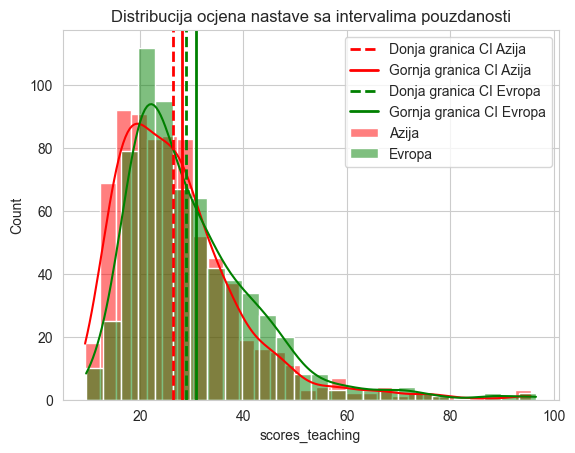

In [15]:


sns.histplot(asia_teaching, kde=True, label='Azija', color='red')
sns.histplot(europe_teaching, kde=True, label='Evropa', color='green')

plt.axvline(ci_low_asia, color='red', linestyle='--', linewidth=2, label='Donja granica CI Azija')
plt.axvline(ci_high_asia, color='red', linestyle='-', linewidth=2, label='Gornja granica CI Azija')

plt.axvline(ci_low_europe, color='green', linestyle='--', linewidth=2, label='Donja granica CI Evropa')
plt.axvline(ci_high_europe, color='green', linestyle='-', linewidth=2, label='Gornja granica CI Evropa')

plt.title("Distribucija ocjena nastave sa intervalima pouzdanosti")
plt.xlabel("scores_teaching")
plt.legend()
plt.show()


Dodali smo linije koje bi trebale da naglase gdje se nalaze granice intervala pouzdanosti. Srednja vrijednost bodovnog indeksa nastavnog procesa u Aziji se kreće u 95-postotnom intervalu **(26.35, 28.12)**, dok je za Evropu vrijednost u **(28.95, 30.92)**. Ovi intervali se uopšte ne poklapaju, što je dodatni dokaz našeg zaključka da Evropa ima kvalitetniji nastavni proces.

Sada pogledajmo drugačiji faktor za nastavni proces, a to je broj studenata na univerzitetu.
Provjerimo t-testom da li ima razlike u kvaliteti nastave zavisno od broja studenata. Klasificirati ćemo univerzitete u tri kategorije: **manje** (sa manje od 5 hiljada studenata), **srednje** (između 5 i 10 hiljada) i **velike** (preko 15 hiljada studenata).

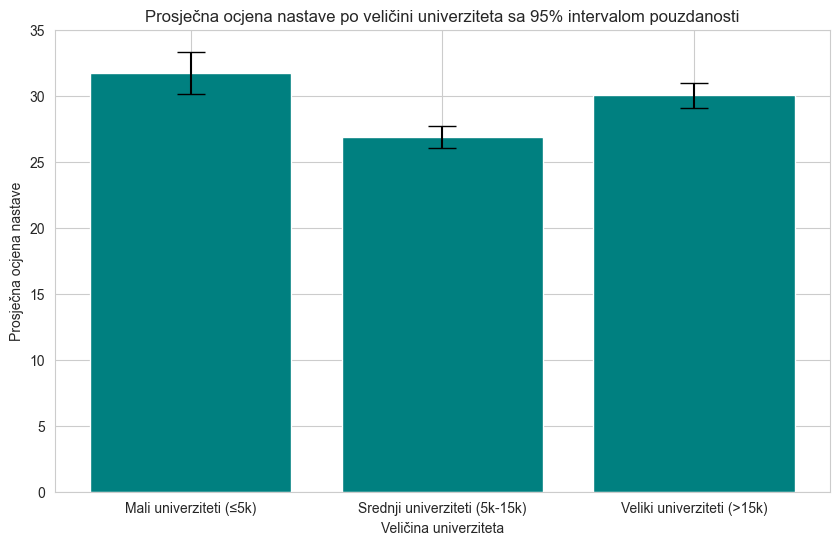

In [16]:
df_ranked_c = df_ranked


df_ranked_c['stats_number_students'] = pd.to_numeric(df_ranked_c['stats_number_students'], errors='coerce')
df_ranked_c['scores_teaching'] = pd.to_numeric(df_ranked_c['scores_teaching'], errors='coerce')

def kategorija_velicine(broj_studenata):
    if broj_studenata <= 5000:
        return 'Mali univerziteti (≤5k)'
    elif broj_studenata <= 15000:
        return 'Srednji univerziteti (5k-15k)'
    else:
        return 'Veliki univerziteti (>15k)'

df_ranked_c['velicina_univerziteta'] = df_ranked_c['stats_number_students'].apply(kategorija_velicine)

def interval_pouzdanosti(podaci, alfa=0.05):
    n = len(podaci)
    srednja_vrijednost = np.mean(podaci)
    sem = stats.sem(podaci)
    h = stats.t.ppf(1 - alfa/2, n - 1) * sem
    return srednja_vrijednost, srednja_vrijednost - h, srednja_vrijednost + h

grupe = df_ranked_c.groupby('velicina_univerziteta')

rezultati = []
for grupa, podaci in grupe:
    nastava = podaci['scores_teaching'].dropna()
    if len(nastava) > 1:
        mean_, low_, high_ = interval_pouzdanosti(nastava)
        rezultati.append((grupa, mean_, low_, high_, len(nastava)))

rezultati_df = pd.DataFrame(rezultati, columns=['Velicina', 'Prosjek', 'Donja granica', 'Gornja granica', 'Broj univerziteta'])

plt.figure(figsize=(10,6))
plt.bar(rezultati_df['Velicina'], rezultati_df['Prosjek'], yerr=[rezultati_df['Prosjek'] - rezultati_df['Donja granica'], rezultati_df['Gornja granica'] - rezultati_df['Prosjek']], capsize=10, color='teal')
plt.title('Prosječna ocjena nastave po veličini univerziteta sa 95% intervalom pouzdanosti')
plt.ylabel('Prosječna ocjena nastave')
plt.xlabel('Veličina univerziteta')
plt.show()

Grafik iznad daje pomalo neočekivanu situaciju. Prosječno najnekvalitetniji proces nastave imaju srednje veliki univerziteti, dok oni najmanji imaju najbolju ocjenu. Provjerimo koristeći t-test da li ima značajne razlike u kvaliteti nastave u ovim podkategorijama.

In [17]:
df_ranked_c = df_ranked

mali = df_ranked_c[df_ranked_c['velicina_univerziteta'] == 'Mali univerziteti (≤5k)']['scores_teaching'].dropna()
veliki = df_ranked_c[df_ranked_c['velicina_univerziteta'] == 'Veliki univerziteti (>15k)']['scores_teaching'].dropna()

t_stat, p_val = stats.ttest_ind(mali, veliki, equal_var=False)

print(f"T-test rezultat: t = {t_stat:.3f}, p = {p_val:.4f}")

if p_val < 0.05:
    print("Statistički značajna razlika u ocjenama nastave između malih i velikih univerziteta (p < 0.05).")
else:
    print("Nema statistički značajne razlike u ocjenama nastave između malih i velikih univerziteta (p ≥ 0.05).")

T-test rezultat: t = 1.798, p = 0.0732
Nema statistički značajne razlike u ocjenama nastave između malih i velikih univerziteta (p ≥ 0.05).


Nakon izvršenog t-testa, dobivamo rezultate takve da je razlika srednjih vrijednosti nastave manjih i velikih univerziteta 1.798 a dok je p vrijednost jednaka 0.0732. Na osnovu toga, može se reći da se razlika u ocjenama nastave između ove dvije grupe može pripisati i slučajnosti, odnosno da **nemamo jasan dokaz da veličina univerziteta utiče na ocjenu nastave.**
Pogledajmo drugi slučaj, gdje sada umjesto velikih koristimo srednje univerzitete.


In [18]:


mali = df_ranked_c[df_ranked_c['velicina_univerziteta'] == 'Mali univerziteti (≤5k)']['scores_teaching'].dropna()
srednji = df_ranked_c[df_ranked_c['velicina_univerziteta'] == 'Srednji univerziteti (5k-15k)']['scores_teaching'].dropna()

t_stat, p_val = stats.ttest_ind(mali, srednji, equal_var=False)

print(f"T-test rezultat: t = {t_stat:.3f}, p = {p_val:.4f}")

if p_val < 0.05:
    print("Statistički značajna razlika u ocjenama nastave između malih i srednjih univerziteta (p < 0.05).")
else:
    print("Nema statistički značajne razlike u ocjenama nastave između malih i srednjih univerziteta (p ≥ 0.05).")

T-test rezultat: t = 5.316, p = 0.0000
Statistički značajna razlika u ocjenama nastave između malih i srednjih univerziteta (p < 0.05).


Nakon ponovno izvršenog t-testa, sada za male i srednje univerzitete, dolazimo do drugačijeg zaključka: **postoji značajna razlika u kvaliteti (ocjeni kvaliteta) nastave na malim i srednjim univerzitetima**, gdje za njihove srednje vrijednosti ona iznosi 5.316.

Kao posljednji primjer ispitati ćemo da li možemo sa sigurnošću da kažemo da univerziteti sa većim brojem stranih studenata imaju značajno veći rezultat u kategoriji međunarodne povezanosti. Kako bismo to izveli, podijeliti ćemo univerzitete u tri podkategorije prema postotku međunarodnih studenata i uraditi t-test.

T-test Nizak vs Srednji: t = -11.281, p = 0.0000
Statistički značajna razlika između grupa 1 (p < 0.05)
T-test Nizak vs Visok: t = -45.274, p = 0.0000
Statistički značajna razlika između grupa 2 (p < 0.05)
T-test Srednji vs Visok: t = -33.095, p = 0.0000
Statistički značajna razlika između grupa 3 (p < 0.05)


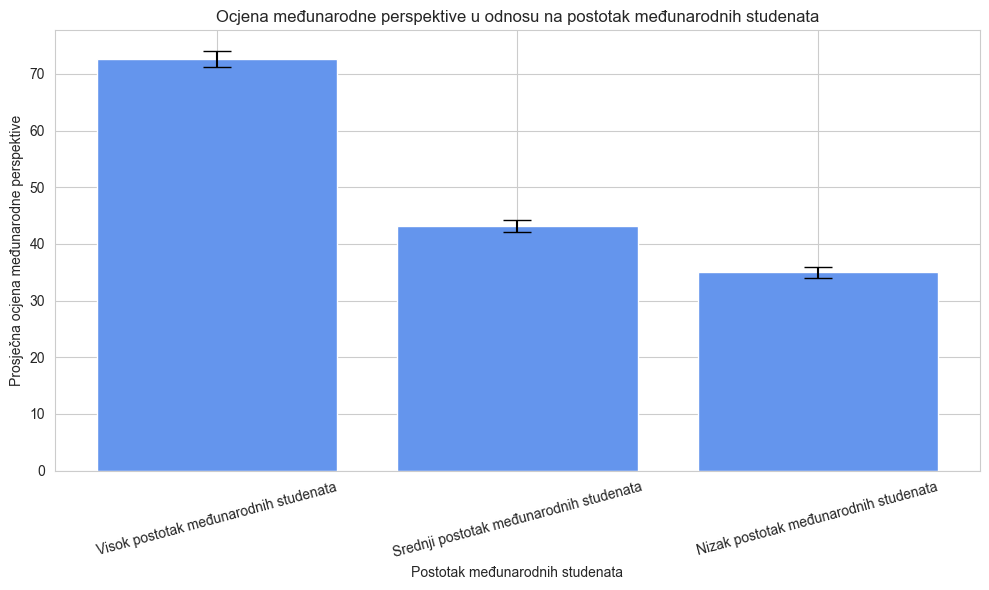

In [19]:


df_ranked_c['stats_pc_intl_students'] = df_ranked_c['stats_pc_intl_students'].astype(str).str.replace('%', '', regex=False).astype(float)
df_ranked_c['scores_international_outlook'] = pd.to_numeric(df_ranked_c['scores_international_outlook'], errors='coerce')

# Podjela na trećine (tercile)
tercili = df_ranked_c['stats_pc_intl_students'].quantile([1/3, 2/3]).values

def intl_grupa(pct):
    if pct <= tercili[0]:
        return 'Nizak postotak međunarodnih studenata'
    elif pct <= tercili[1]:
        return 'Srednji postotak međunarodnih studenata'
    else:
        return 'Visok postotak međunarodnih studenata'

df_ranked_c['intl_grupa'] = df_ranked_c['stats_pc_intl_students'].apply(intl_grupa)

# Priprema grupa
donja = df_ranked_c[df_ranked_c['intl_grupa'] == 'Nizak postotak međunarodnih studenata']['scores_international_outlook'].dropna()
srednja = df_ranked_c[df_ranked_c['intl_grupa'] == 'Srednji postotak međunarodnih studenata']['scores_international_outlook'].dropna()
gornja = df_ranked_c[df_ranked_c['intl_grupa'] == 'Visok postotak međunarodnih studenata']['scores_international_outlook'].dropna()

# T-testovi i zaključci
def ttest_i_ispis(grupa1, grupa2, ime1, ime2, redni_broj):
    if len(grupa1) > 1 and len(grupa2) > 1:
        t, p = stats.ttest_ind(grupa1, grupa2, equal_var=False)
        print(f"T-test {ime1} vs {ime2}: t = {t:.3f}, p = {p:.4f}")
        if p < 0.05:
            print(f"Statistički značajna razlika između grupa {redni_broj} (p < 0.05)")
        else:
            print(f"Nema statistički značajne razlike između grupa {redni_broj} (p ≥ 0.05)")
    else:
        print(f"Nedovoljno podataka za t-test {ime1} vs {ime2}")

ttest_i_ispis(donja, srednja, 'Nizak', 'Srednji', 1)
ttest_i_ispis(donja, gornja, 'Nizak', 'Visok', 2)
ttest_i_ispis(srednja, gornja, 'Srednji', 'Visok', 3)

# Interval pouzdanosti
def interval_pouzdanosti(podaci, alfa=0.05):
    n = len(podaci)
    mean = np.mean(podaci)
    sem = stats.sem(podaci)
    h = stats.t.ppf(1 - alfa/2, n - 1) * sem
    return mean, mean - h, mean + h

# Priprema za graf
rezultati = []
for grupa in df_ranked_c['intl_grupa'].unique():
    podaci = df_ranked_c[df_ranked_c['intl_grupa'] == grupa]['scores_international_outlook'].dropna()
    if len(podaci) > 1:
        mean, low, high = interval_pouzdanosti(podaci)
        rezultati.append((grupa, mean, low, high))

rezultati_df = pd.DataFrame(rezultati, columns=['Grupa', 'Prosjek', 'Donja granica', 'Gornja granica'])

# Vizualizacija
plt.figure(figsize=(10,6))
plt.bar(rezultati_df['Grupa'], rezultati_df['Prosjek'], 
        yerr=[rezultati_df['Prosjek'] - rezultati_df['Donja granica'], 
              rezultati_df['Gornja granica'] - rezultati_df['Prosjek']], 
        capsize=10, color='cornflowerblue')
plt.title('Ocjena međunarodne perspektive u odnosu na postotak međunarodnih studenata')
plt.ylabel('Prosječna ocjena međunarodne perspektive')
plt.xlabel('Postotak međunarodnih studenata')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

Ovdje zaista nemamo potrebe da mnogo šta govorimo. Izvršeni proračun kao i grafički prikaz nam bez ikakve dileme daju odgovor da sa sigurnošću od 95% možemo kazati da **univerziteti sa većim postotkom stranih studenata ujedno imaju i veću ocjenu po pitanju međunarodne otvorenosti**.

### 6. Estimacija pouzdanosti proporcije _(eng. proportion confidence intervals)_


Član tima: **Tarik Redžić**

---

Estimacija tačke proporcije _p_ u binomnom eksperimentu daje se statistikom
$\hat{P} = \frac{X}{n}$
gdje _X_ predstavlja broj uspjeha u _n_ pokušaja. Stoga će se uzorčna proporcija
$\hat{p} = \frac{x}{n}$
koristiti kao tačka parametra _p_.

Ako se ne očekuje da je nepoznata proporcija _p_ previše blizu 0 ili 1, možemo uspostaviti interval pouzdanosti za _p_ razmatrajući raspodjelu uzorka statistike $\hat{P}$. Označavajući neuspjeh u svakom binomnom pokušaju sa vrijednošću 0, a uspjeh sa vrijednošću 1, broj uspjeha _x_ može se tumačiti kao zbroj od _n_ vrijednosti koje se sastoje samo od 0 i 1, a $\hat{p}$ je zapravo uzorčni prosjek tih _n_ vrijednosti.

$\hat{p} - z_{\frac{\alpha}{2}} \sqrt{\frac{\hat{p}\hat{q}}{n}} < p < \hat{p} + z_{\frac{\alpha}{2}} \sqrt{\frac{\hat{p}\hat{q}}{n}}$


Da bi se procijenila razlika između dviju populacionih proporcija pomoću intervala pouzdanosti, može se koristiti Centralni granični teorem kada su veličine uzoraka dovoljno velike (svaka barem 30). Kada je statistička osobina koju posmatramo, poput mišljenja o nekom pitanju (podržava/ne podržava), kategorička, ljudi žele izvještavati o razlikama između dviju proporcije populacije — na primjer, razlika između udjela žena i muškaraca koji podržavaju četverodnevnu radnu sedmicu.

Kako se to radi?

Razliku između dviju populacionih proporcija, $p_1 - p_2$,
procjenjujemo tako što uzmemo uzorak iz svake populacije i koristimo razliku između dviju uzoraka proporcija, $\hat{p}_1 - \hat{p}_2$ plus ili minus margina greške. Dobijeni rezultat se naziva interval pouzdanosti za razliku između dviju populacionih proporcija $p_1 - p_2$

**Formula za interval pouzdanosti (CI)** za razliku između dviju populacionih proporcija glasi:

#### $\left( \hat{p}_1 - \hat{p}_2 \right) \pm z^{*} \sqrt{\frac{\hat{p}_1 \left(1 - \hat{p}_1\right)}{n_1} +\frac{\hat{p}_2 \left(1 - \hat{p}_2\right)}{n_2}}$

- $\hat{p}_1$ i $n_1$ — uzorak proporcija i veličina uzorka iz **prvog** uzorka  
- $\hat{p}_2$ i $n_2$ — uzorak proporcija i veličina uzorka iz **drugog** uzorka  
- $z^*$ — odgovarajuća vrijednost iz **standardne normalne distribucije** za željeni nivo pouzdanosti (npr. za 95% pouzdanost, $z^* \approx 1.96$)

Ova formula daje interval pouzdanosti za razliku između dvije populacione proporcije na osnovu uzoraka.



## **Statistička inferencija seta podataka**

Da bi na osnovu do sada posmatranog seta podataka uspjeli istaknuti konkretne i korisne zaključke, u ovom poglavlju ćemo primjeniti metodu statističkog inferenciranja, testiranje statističkih hipoteza (eng. statistical hypothesis testing).

...

**Hipoteza H0:** Balkanske članice Evropske Unije prosječno imaju bolje rezultate za istraživačko citiranje u odnosu na Balkanske zemlje koje nisu članice. (Predstavlja: Adnan Muradbegović)<br>
**Hipoteza H1:** Univerziteti sa manje studenata po nastavnom osoblju imaju prosječno bolje rezultate za nastavu. (Predstavlja: Zlatan Ljutika)<br>
**Hipoteza H2:** Državni univerziteti imaju prosječno bolje rezultate za nastavu od privatnih. (Predstavlja: Aid Mustafić)<br>
**Hipoteza H3:** Međunarodna povezanost Univerziteta u Sarajevu je značajno ispod evropskog prosjeka (Predstavlja: Tarik Redžić)<br>

### 2.1. **Hipoteza:** Balkanske članice Evropske Unije prosječno imaju veći broj bodova za istraživačko citiranje u odnosu na Balkanske zemlje koje nisu članice.

Član tima: **Adnan Muradbegović**

---

### 2.2. **Hipoteza:** Univerziteti sa manje studenata po nastavnom osoblju imaju više bodova za nastavu.
Član tima: **Ljut**

---

### 2.3. **Hipoteza:** Državni univerziteti imaju prosječno bolje rezultate za nastavu od privatnih.

Član tima: **Aid Mustafić**

---

U neposustajućoj debati između državnih i privatnih univerziteta često se provlači predrasuda da, **uprkos većim ulaganjima u privatne institucije, državni univerziteti,** zahvaljujući svojoj reputaciji i tradiciji, **imaju kvalitetniji nastavni kadar** i obrazuju stručnije diplomante.


Hipoteze za ovu tvrdnju glase:
> <h5><b><i>Null</i> hipoteza [H0]:</b> Državni i privatni univerziteti imaju isti prosječni rezultat za nastavni proces.<br> 
> <b>Alternativna hipoteza [H1]:</b> Državni univerziteti imaju prosječno bolje rezultate za nastavni proces od privatnih.</h5> 


Sada posmatrajmo uzorak: _Koliko je univerziteta na rang-listi zapravo privatnih, a koliko državnih?_

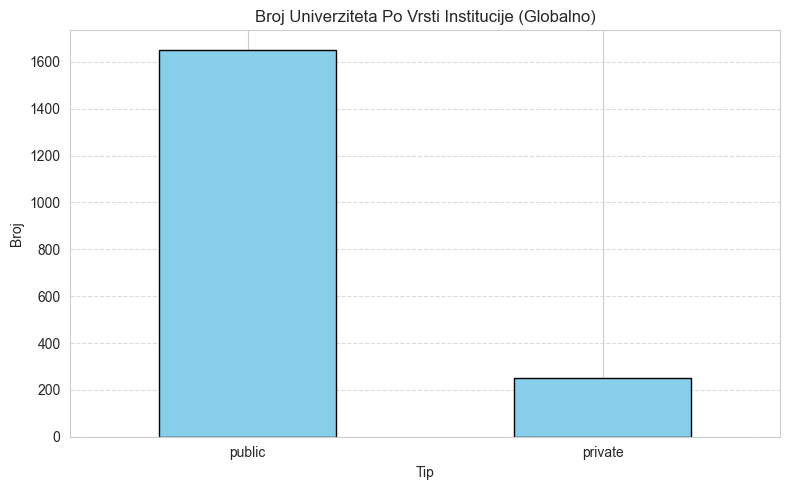

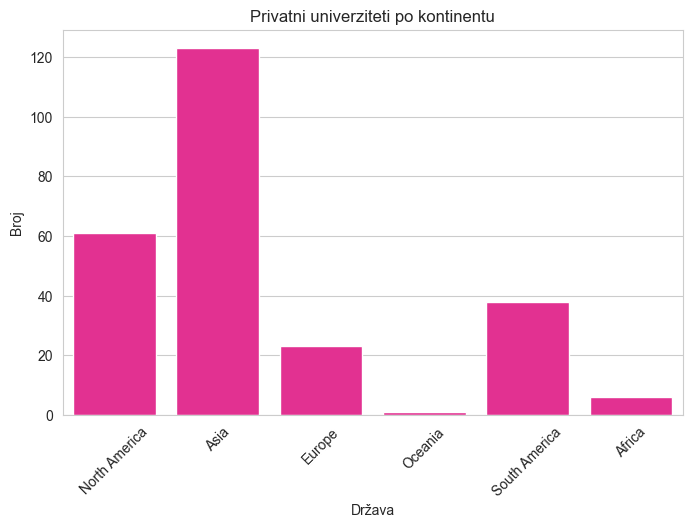

Ukupno 252 privatna univerziteta.


In [53]:
df_ranked.loc[df_ranked['record_type'] == 'master_account', 'record_type'] = 'public'
df1 = pd.read_csv('universities_classified.csv') # Jako važno!

classification_map = {
    name: str(classification).lower() 
    for name, classification in zip(df1['name'], df1['classification'])
}

# Update record_type in df2 where names match
df_ranked['record_type'] = df_ranked['name'].map(classification_map).fillna(df_ranked['record_type'])



record_counts = df_ranked['record_type'].value_counts()
plt.figure(figsize=(8, 5))
record_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Broj Univerziteta Po Vrsti Institucije (Globalno)')
plt.xlabel('Tip')
plt.ylabel('Broj')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(data=df_ranked[df_ranked['record_type'] == 'private'], x='continent',color="deeppink")
plt.title('Privatni univerziteti po kontinentu')
plt.xlabel("Država")
plt.ylabel("Broj")
plt.xticks(rotation=45)
plt.show()
print("Ukupno "+str(len(df_ranked[df_ranked['record_type'] == 'private'])) + " privatna univerziteta.")

**Napomena:** Inicijalno, ovaj dataset je imao problem sa klasificiranjem privatne i državne institiucije, gdje je za **94% seta podataka zapisano "master_account" kao N/A podatak.**  
Koristeći [Lutra AI](https://lutra.ai/), uspjeli smo automatizirati proces pravilnog klasificiranja, **mada nije van razuma očekivati greške u zapisu ili interpretaciji koju je ovaj AI agent postavio.**

Prethodno, kao _'privatni'_ je isključivo bilo klasificirano samo _58 institucija iz Sjedinjenih Američkih Država_, te ćemo i to posebno posmatrati.

**Ovu hipotezu ćemo ispitati** na nivou značajnosti $\alpha = 0{.}05$ , uz uzorak veličine $n = 252$, odgovarajući broju globalno rangiranih privatnih univerziteta.   
Kako se radi o većem uzorku nepoznate varijanse i srednje vrijednosti populacije, **za test-statistiku ćemo koristiti t-distribuciju.**    

Da bi estimirali parametar $\theta$, za *point estimator* je najprirodnije uzeti **srednju vrijednost uzorka**, koja je data formulom:
##### $\bar{x} = \frac{1}{251} \sum_{i=1}^{252} x_i$

Sada možemo preći na uzorkovanje.  
Iz uzorka državnih univerziteta ćemo nasumično uzorkovati, odnosno, dublje suziti uzorak na $n = 252$, te testirati distribucije uzorkovanja na normalnost _putem Q-Q plot testa_:

,rank,name,scores_overall,scores_overall_rank,scores_teaching,scores_teaching_rank,scores_research,scores_research_rank,scores_citations,scores_citations_rank,...,scores_research_imputed,scores_citations_imputed,scores_industry_income_imputed,scores_international_outlook_imputed,stats_female_male_ratio_imputed,subjects_offered_imputed,website_url_imputed,continent,velicina_univerziteta,intl_grupa
0,1,University of Oxford,98.5,10,96.60,5,100.00,2,99.00,5,...,False,False,False,False,False,False,False,Europe,Veliki univerziteti (>15k),Visok postotak međunarodnih studenata
22,23,University of Michigan-Ann Arbor,87.4,230,84.70,22,87.40,23,95.50,45,...,False,False,False,False,False,False,False,North America,Veliki univerziteti (>15k),Visok postotak međunarodnih studenata
24,25,University of Washington,85.3,250,78.00,27,83.50,29,98.20,11,...,False,False,False,False,False,False,False,North America,Veliki univerziteti (>15k),Visok postotak međunarodnih studenata


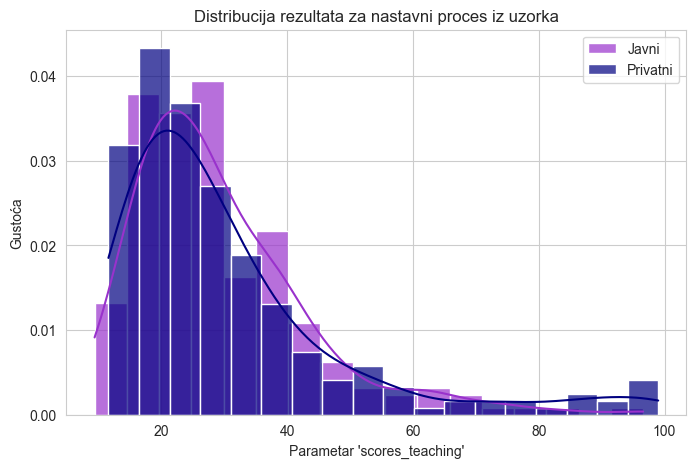

In [74]:
global_uzorak_drzavni = df_ranked[df_ranked['record_type'] == 'public'].sample(n=252, random_state=90).sort_values('scores_overall_rank')
global_uzorak_privatni = df_ranked[df_ranked['record_type']=='private']

global_public = global_uzorak_drzavni['scores_teaching']
global_private = global_uzorak_privatni['scores_teaching']
display(global_uzorak_drzavni.head(3))
plt.figure(figsize=(8, 5))
sns.histplot(global_uzorak_drzavni['scores_teaching'], color='darkorchid', label='Javni', kde=True, stat="density", alpha=0.7)
sns.histplot(global_uzorak_privatni['scores_teaching'], color='navy', label='Privatni', kde=True, stat="density", alpha=0.7)
plt.legend()
plt.title("Distribucija rezultata za nastavni proces iz uzorka")
plt.xlabel("Parametar 'scores_teaching'")
plt.ylabel("Gustoća")
plt.show()

Iako postoje test statistike gdje se **ne pretpostavlja normalnost**, _pokušati ćemo djelovanjem logaritma na funkcije distribucija dobiti normalnu, tj. lognormalnu distribuciju._

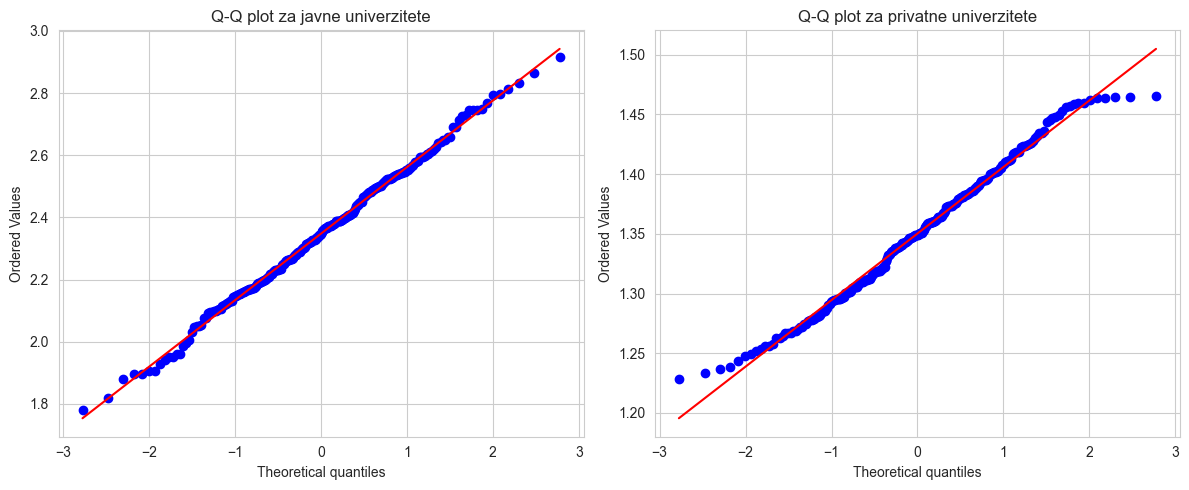

Statistika=0.9871, P-vrijednost=0.0233
Uzorci prate NORMALNU distribuciju! (po Shapiro-Wilk testu normalnosti)


In [76]:
plt.figure(figsize=(12, 5))

from scipy.stats import boxcox
transformed_data, lambda_val = boxcox(global_private)
transfomed_data, lambda_val = boxcox(global_public)
plt.subplot(1, 2, 1)
stats.probplot(transfomed_data, dist="norm", plot=plt)
plt.title("Q-Q plot za javne univerzitete")
plt.subplot(1, 2, 2)
stats.probplot(transformed_data, dist="norm", plot=plt)
plt.title("Q-Q plot za privatne univerzitete")

plt.tight_layout()
plt.show()

stat, global_p_value = stats.shapiro(transformed_data)
stat2, global_p_value2 = stats.shapiro(transfomed_data)
print(f'Statistika={stat:.4f}, P-vrijednost={global_p_value:.4f}')

if   global_p_value2> 0.05:
    print("Uzorci prate NORMALNU distribuciju! (po Shapiro-Wilk testu normalnosti)")
else:
    print("Uzorci ne prate NORMALNU distribuciju!")


Poštivajući **Teorem centralne granice**, imamo dovoljno velik uzorak gdje _prividna nenormalnost distribucija_ je prihvatljivo zanemariti u ovoj observaciji, obzirom da tačno posmatramo distribucije srednje vrijednosti ova dva uzorka.  

Konačno, pokrenimo kod za našu t-statistiku.

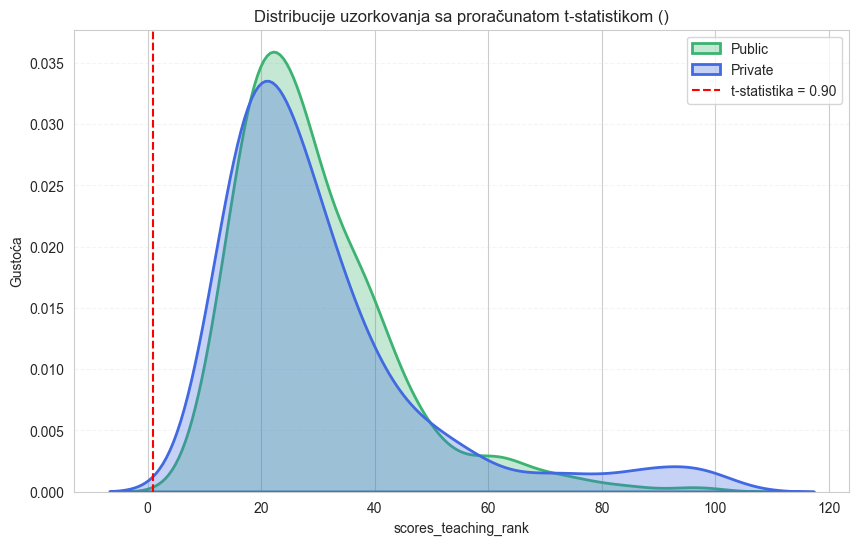

Z-statistika: -0.716
t-statistika: -0.72
p-vrijednost: 0.763
Snaga testa: 0.9%


In [80]:



globalt_stat, p_value = ttest_ind(global_public, global_private, alternative='greater', equal_var=False)

global_mean_public, mean_global_private = np.mean(global_public), np.mean(global_private)
globalstd_public, std_global_private = np.std(global_public, ddof=1), np.std(global_private, ddof=1)
globaln_public, n_global_private = len(global_public), len(global_private)

globalpooled_std = np.sqrt(((globaln_public - 1) * globalstd_public**2 + (n_global_private - 1) * std_global_private**2) / (globaln_public + n_global_private - 2))
globaleffect_size = (global_mean_public - mean_global_private) / globalpooled_std

globalpower = TTestIndPower().power(effect_size=globaleffect_size, nobs1=globaln_public, alpha=0.05, ratio=n_global_private/globaln_public, alternative='larger')

plt.figure(figsize=(10, 6))
sns.kdeplot(global_public, color='mediumseagreen', label='Public', fill=True, alpha=0.3, linewidth=2)
sns.kdeplot(global_private, color='royalblue', label='Private', fill=True, alpha=0.3, linewidth=2)
plt.axvline(t_stat, color='red', linestyle='--', label=f't-statistika = {t_stat:.2f}')
plt.xlabel('scores_teaching_rank')
plt.ylabel('Gustoća')
plt.title('Distribucije uzorkovanja sa proračunatom t-statistikom ()')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.show()

globalz_stat, globalp_value = ztest(global_public, global_private, alternative='larger')

print(f"Z-statistika: {globalz_stat:.3f}")
print(f"t-statistika: {globalt_stat:.2f}")
print(f"p-vrijednost: {globalp_value:.3f}")
print(f"Snaga testa: {globalpower:.1%}")

Na osnovu dobijenih rezultata:, t-statistika iznosi -0.72 i p-vrijednošću od 0.763, snaga testa je 0.9%, što ukazuje na vrlo visoku osjetljivost na grešku tipa II.

Vidimo da je i $z \approx t = -0.716$, dakle test normalnosti je bio i dijelom suvišan.

**Zaključak:**  
**Ne postoji statistički značajna razlika (p > 0.05) između grupa.** Dobivena t-statistika ukazuje na izuzetno malu razliku između srednjih vrijednosti, što potvrđuje i vizuelna procjena preklapanja distribucija. Niska snaga testa upozorava da bi veći uzorak mogao dati preciznije rezultate, ali trenutni podaci ne pokazuju značajne razlike.  
Dakle, iz podataka **nismo mogli zaključiti da prosječno državni univerziteti su se bolje plasirali po rangiranju nastave.**


---

Iz prethodne pojave outliera u distribuciji privatnih univerziteta, nije van razuma pretpostaviti da su _Ivy League_ univerziteti, grupacija od svega 8 univerziteta igrali neku ulogu. Obzirom da status konkretno privatnih univerziteta zavisi od jednog državnog uređenja do drugog, posmatrati ćemo konkretno stanje od interesa na evropskom kontinentu. Da li i tu vidimo slično ponašanje?

Hipoteze za ovu tvrdnju glase:
> <h5><b><i>Null</i> hipoteza [H0]:</b> Državni i privatni univerziteti <b>u Evropi </b>imaju isti prosječni rezultat za nastavni proces.<br> 
> <b>Alternativna hipoteza [H1]:</b> Državni univerziteti  <b>u Evropi</b> imaju prosječno bolje rezultate za nastavni proces od privatnih.</h5> 



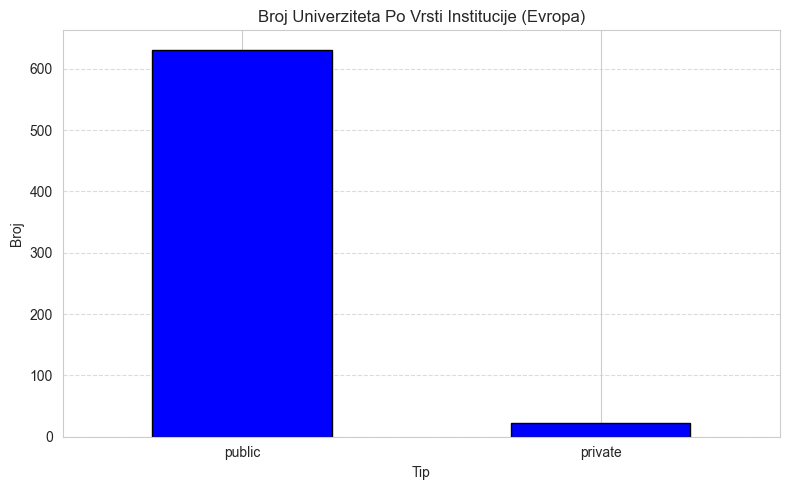

Ukupno 631 državni univerzitet i 23 privatna univerziteta.


In [24]:
eu_df = df_ranked[df_ranked['continent']=='Europe']

plt.figure(figsize=(8, 5))
eu_df['record_type'].value_counts().plot(kind='bar', color='blue', edgecolor='black')
plt.title('Broj Univerziteta Po Vrsti Institucije (Evropa)')
plt.xlabel('Tip')
plt.ylabel('Broj')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Ukupno "+str(eu_df['record_type'].value_counts()['public'])+ ' državni univerzitet i ' + str(eu_df['record_type'].value_counts()['private']) + " privatna univerziteta.")

**Ovu hipotezu ćemo ispitati** na nivou značajnosti $\alpha = 0{.}10$ , uz uzorak veličine $n = 28$.   
Kako se radi o relativno malom uzorku, **za test-statistiku ćemo koristiti t-distribuciju.**    

Da bi estimirali parametar $\theta$, za *point estimator* je najprirodnije uzeti **srednju vrijednost uzorka**, koja je data formulom:
##### $\bar{x} = \frac{1}{27} \sum_{i=1}^{28} x_i$

Sada možemo preći na uzorkovanje.  
Iz uzorka državnih univerziteta ćemo nasumično uzorkovati, odnosno, dublje suziti uzorak na $n = 28$:

,rank,name,scores_overall,scores_overall_rank,scores_teaching,scores_teaching_rank,scores_research,scores_research_rank,scores_citations,scores_citations_rank,...,scores_research_imputed,scores_citations_imputed,scores_industry_income_imputed,scores_international_outlook_imputed,stats_female_male_ratio_imputed,subjects_offered_imputed,website_url_imputed,continent,velicina_univerziteta,intl_grupa
1898,1501+,University of West Attica,9.7–22.7,18990,10.00,1901,9.70,1692,34.70,1332,...,False,False,False,False,False,False,True,Europe,Veliki univerziteti (>15k),Nizak postotak međunarodnih studenata
1890,1501+,Instituto Politécnico de Viana do Castelo,9.7–22.7,18910,13.00,1847,9.60,1704,35.40,1316,...,False,False,False,False,False,False,True,Europe,Srednji univerziteti (5k-15k),Srednji postotak međunarodnih studenata
623,601–800,Birmingham City University,37.0–41.8,6240,17.30,1605,11.80,1422,77.80,372,...,False,False,False,False,False,False,False,Europe,Veliki univerziteti (>15k),Visok postotak međunarodnih studenata


,rank,name,scores_overall,scores_overall_rank,scores_teaching,scores_teaching_rank,scores_research,scores_research_rank,scores_citations,scores_citations_rank,...,scores_research_imputed,scores_citations_imputed,scores_industry_income_imputed,scores_international_outlook_imputed,stats_female_male_ratio_imputed,subjects_offered_imputed,website_url_imputed,continent,velicina_univerziteta,intl_grupa
1472,1201–1500,UNIR – International University of La Rioja,22.8–28.2,14730,11.90,1879,13.90,1218,38.00,1258,...,False,False,False,False,False,False,True,Europe,Veliki univerziteti (>15k),Visok postotak međunarodnih studenata
1170,1001–1200,SWPS University of Social Sciences and Humanities,28.3–32.6,11710,12.80,1855,16.40,1022,53.00,943,...,False,False,False,False,False,False,True,Europe,Veliki univerziteti (>15k),Srednji postotak međunarodnih studenata
1240,1201–1500,Universidad Católica San Antonio de Murcia (UCAM),22.8–28.2,12410,16.70,1650,14.30,1175,33.90,1351,...,False,False,False,False,False,False,True,Europe,Srednji univerziteti (5k-15k),Visok postotak međunarodnih studenata


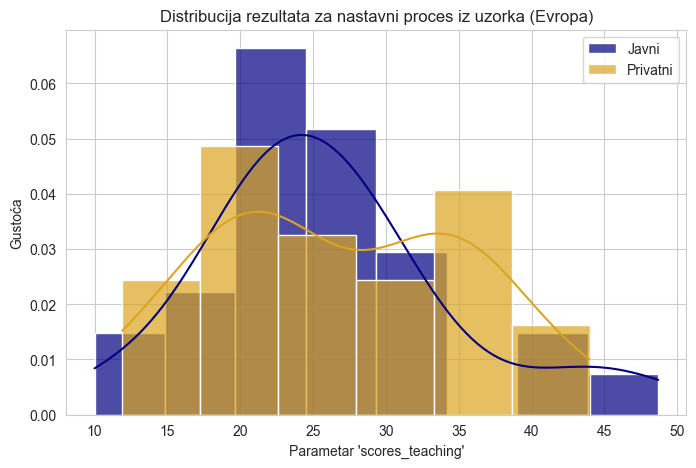

In [86]:
eu_uzorak_drzavni = eu_df[eu_df['record_type'] == 'public'].sample(n=28, random_state=11).sort_values('scores_teaching_rank',ascending=False)
eu_uzorak_privatni = eu_df[eu_df['record_type']=='private'].sort_values('scores_teaching_rank',ascending=False)

eu_public = eu_uzorak_drzavni['scores_teaching']
eu_private = eu_uzorak_privatni['scores_teaching']
display(eu_uzorak_drzavni.head(3))
display(eu_uzorak_privatni.head(3))
plt.figure(figsize=(8, 5))
sns.histplot(eu_uzorak_drzavni['scores_teaching'], color='navy', label='Javni', kde=True, stat="density", alpha=0.7)
sns.histplot(eu_uzorak_privatni['scores_teaching'], color='goldenrod', label='Privatni', kde=True, stat="density", alpha=0.7)
plt.legend()
plt.title("Distribucija rezultata za nastavni proces iz uzorka (Evropa)")
plt.xlabel("Parametar 'scores_teaching'")
plt.ylabel("Gustoća")
plt.show()

Kako radimo sa *vrlo niskim uzorkom*, $n <30$, ovdje je **nužno** ispitati normalnost.

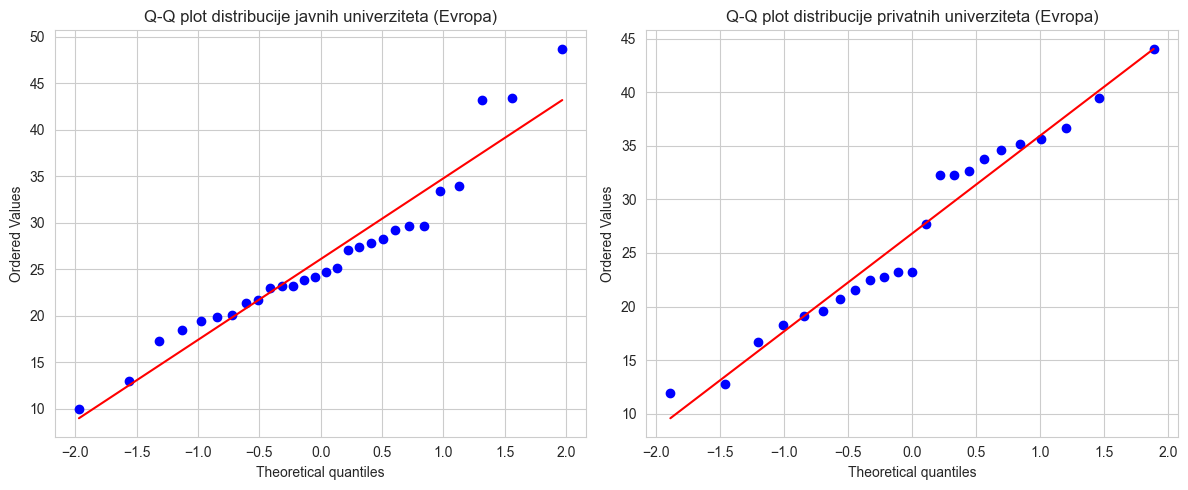

Statistika=0.9531, P-vrijednost=0.7627
Uzorci prate NORMALNU distribuciju! (po Shapiro-Wilk testu normalnosti)


In [87]:
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
stats.probplot(eu_public, dist="norm", plot=plt)
plt.title("Q-Q plot distribucije javnih univerziteta (Evropa)")
plt.subplot(1, 2, 2)
stats.probplot(eu_private, dist="norm", plot=plt)
plt.title("Q-Q plot distribucije privatnih univerziteta (Evropa)")

plt.tight_layout()
plt.show()


stat, eu_p_value = stats.shapiro(eu_private)
stat2, eu_p_value2 = stats.shapiro(eu_public)
print(f'Statistika={stat:.4f}, P-vrijednost={p_value:.4f}')

if eu_p_value > 0.05 and eu_p_value2 > 0.05:
    print("Uzorci prate NORMALNU distribuciju! (po Shapiro-Wilk testu normalnosti)")
else:
    print("Uzorci ne prate NORMALNU distribuciju!")


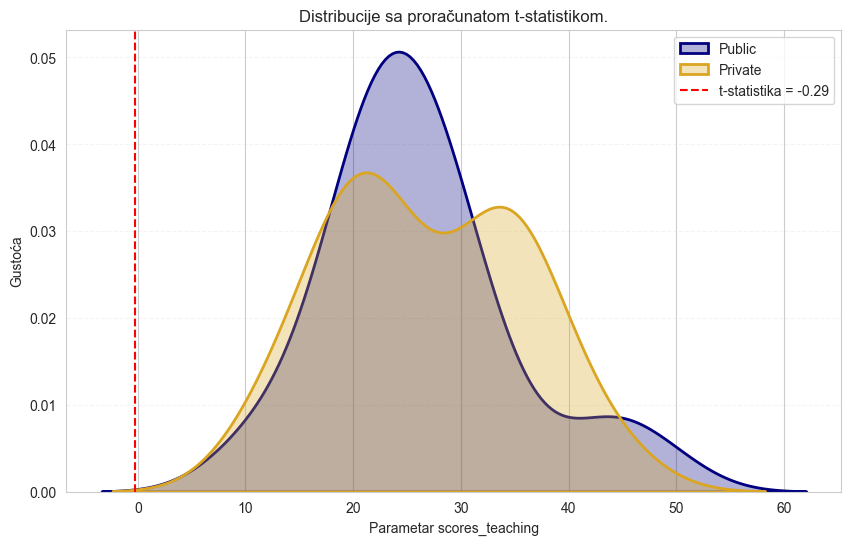

t-statistika: -0.29
p-vrijednost: 0.385
Snaga testa: 8.8%


In [88]:


eu_t_stat, eu_p_value = ttest_ind(eu_public, eu_private, alternative='less', equal_var=False)

eu_mean_public, eu_mean_private = np.mean(eu_public), np.mean(eu_private)
eustd_public, eustd_private = np.std(eu_public, ddof=1), np.std(eu_private, ddof=1)
eun_public, eun_private = len(eu_public), len(eu_private)

eupooled_std = np.sqrt(((eun_public - 1) * eustd_public**2 + (eun_private - 1) * eustd_private**2) / (eun_public + eun_private - 2))
eueffect_size = (eu_mean_public - eu_mean_private) / eupooled_std

eupower = TTestIndPower().power(effect_size=eueffect_size, nobs1=eun_public, alpha=0.05, ratio=eun_private/eun_public, alternative='smaller')

plt.figure(figsize=(10, 6))
sns.kdeplot(eu_public, color='navy', label='Public', fill=True, alpha=0.3, linewidth=2)
sns.kdeplot(eu_private, color='goldenrod', label='Private', fill=True, alpha=0.3, linewidth=2)
plt.axvline(eu_t_stat, color='red', linestyle='--', label=f't-statistika = {eu_t_stat:.2f}')
plt.xlabel('Parametar scores_teaching')
plt.ylabel('Gustoća')
plt.title('Distribucije sa proračunatom t-statistikom.')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.show()

print(f"t-statistika: {eu_t_stat:.2f}")
print(f"p-vrijednost: {eu_p_value:.3f}")
print(f"Snaga testa: {eupower:.1%}")

Mada ovdje vidimo ljepši slučaj, nažalost je **očito da nemamo dovoljno podataka da odbijemo i ovu null hipotezu**, obzirom na uveliko preklapanje i malu pojavu t-statistike. Ovo naročito podržava uvelika razlika p-vrijednosti, čak i na povišenom nivou signifikatnosti $\alpha = 0.05$.

Zaključno, pretpostavka da državni univerziteti su više rangirani po pitanju same nastave, sa ovim uzorkom nije osnovana.

### **Dodatak**
Obzirom da u SAD-u se pretežno *privatne instuticije* smatraju prestižnijim, iako smo već dovoljno utvrdili naš zaključak, kao dodatak ćemo posmatrati i ovu regiju te ispitati:

> <h5><b><i>Null</i> hipoteza [H0]:</b> Državni i privatni univerziteti <b>u SAD-u </b>imaju isti prosječni rezultat za nastavni proces.<br> 
> <b>Alternativna hipoteza [H1]: Privatni univerziteti  u SAD-u</b> imaju prosječno bolje rezultate za nastavni proces od privatnih.</h5> 

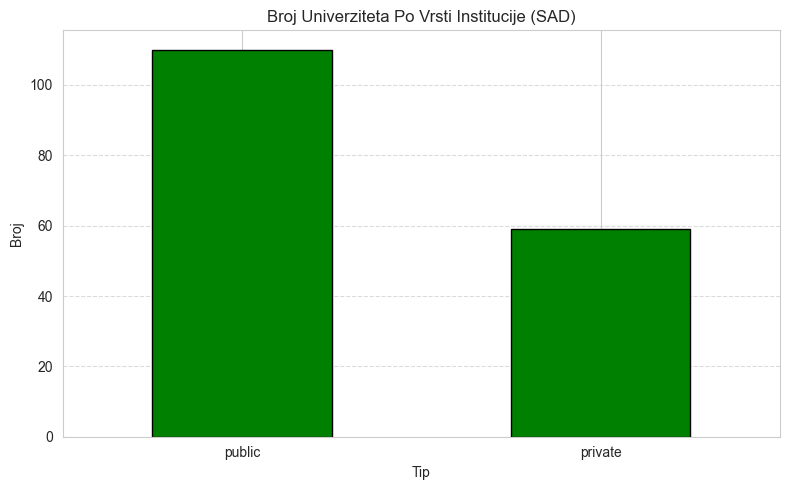

Ukupno 110 državnih univerziteta i 59 privatnih univerziteta.


In [28]:
usa_df = df_ranked[df_ranked['location']=='United States']
record_counts = usa_df['record_type'].value_counts()
plt.figure(figsize=(8, 5))
record_counts.plot(kind='bar', color='green', edgecolor='black')
plt.title('Broj Univerziteta Po Vrsti Institucije (SAD)')
plt.xlabel('Tip')
plt.ylabel('Broj')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


print("Ukupno "+str(usa_df['record_type'].value_counts()['public'])+ ' državnih univerziteta i ' + str(usa_df['record_type'].value_counts()['private']) + " privatnih univerziteta.")

**Ovu hipotezu ćemo ispitati** na nivou značajnosti $\alpha = 0{.}05$ , uz uzorak veličine $n = 59$, odgovarajući broju rangiranih privatnih univerziteta.   
Kako se radi o većem uzorku nepoznate varijanse i srednje vrijednosti populacije, **za test-statistiku ćemo koristiti z-distribuciju.**    

$\theta$ *point estimator* je dat formulom: 
##### $\bar{x} = \frac{1}{58} \sum_{i=1}^{59} x_i$

Sada možemo preći na uzorkovanje.  
Iz uzorka državnih univerziteta ćemo nasumično uzorkovati, odnosno, dublje suziti uzorak na $n = 59$, te testirati distribucije uzorkovanja na normalnost _putem Q-Q plot testa_:

,rank,name,scores_overall,scores_overall_rank,scores_teaching,scores_teaching_rank,scores_research,scores_research_rank,scores_citations,scores_citations_rank,...,scores_research_imputed,scores_citations_imputed,scores_industry_income_imputed,scores_international_outlook_imputed,stats_female_male_ratio_imputed,subjects_offered_imputed,website_url_imputed,continent,velicina_univerziteta,intl_grupa
8,9,"University of California, Berkeley",94.6,90,87.20,18,98.80,4,99.00,4,...,False,False,False,False,False,False,False,North America,Veliki univerziteti (>15k),Visok postotak međunarodnih studenata
33,34,"University of California, San Diego",81.0,340,66.00,53,78.40,35,97.60,19,...,False,False,False,False,False,False,False,North America,Veliki univerziteti (>15k),Visok postotak međunarodnih studenata
35,36,Georgia Institute of Technology,80.0,360,63.40,63,78.90,33,94.10,57,...,False,False,False,False,False,False,False,North America,Veliki univerziteti (>15k),Visok postotak međunarodnih studenata


,rank,name,scores_overall,scores_overall_rank,scores_teaching,scores_teaching_rank,scores_research,scores_research_rank,scores_citations,scores_citations_rank,...,scores_research_imputed,scores_citations_imputed,scores_industry_income_imputed,scores_international_outlook_imputed,stats_female_male_ratio_imputed,subjects_offered_imputed,website_url_imputed,continent,velicina_univerziteta,intl_grupa
1,2,Stanford University,98.0,20,99.00,1,97.80,8,99.60,2,...,False,False,False,False,False,False,True,North America,Srednji univerziteti (5k-15k),Visok postotak međunarodnih studenata
2,3,Massachusetts Institute of Technology,97.9,30,98.60,2,96.20,11,99.70,1,...,False,False,False,False,False,False,False,North America,Srednji univerziteti (5k-15k),Visok postotak međunarodnih studenata
3,4,Harvard University,97.8,40,97.70,3,99.90,3,99.40,3,...,False,False,False,False,False,False,False,North America,Veliki univerziteti (>15k),Visok postotak međunarodnih studenata


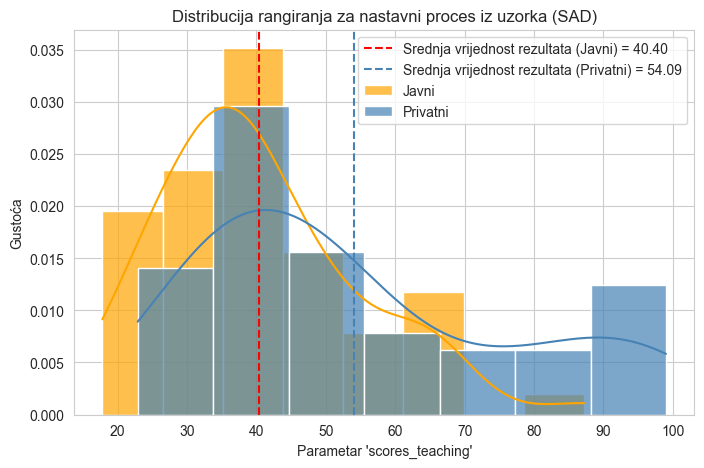

In [91]:
usa_uzorak_drzavni = usa_df[usa_df['record_type'] == 'public'].sample(n=59, random_state=42).sort_values('scores_overall_rank')
usa_uzorak_privatni = usa_df[usa_df['record_type']=='private']

usa_public = usa_uzorak_drzavni['scores_teaching']
usa_private = usa_uzorak_privatni['scores_teaching']
display(usa_uzorak_drzavni.head(3))
display(usa_uzorak_privatni.head(3))
plt.figure(figsize=(8, 5))
sns.histplot(usa_uzorak_drzavni['scores_teaching'], color='orange', label='Javni', kde=True, stat="density", alpha=0.7)
sns.histplot(usa_uzorak_privatni['scores_teaching'], color='steelblue', label='Privatni', kde=True, stat="density", alpha=0.7)
plt.axvline(usa_public.mean(), color='red', linestyle='--', label=f'Srednja vrijednost rezultata (Javni) = {usa_public.mean():.2f}')
plt.axvline(usa_private.mean(), color='steelblue', linestyle='--', label=f'Srednja vrijednost rezultata (Privatni) = {usa_private.mean():.2f}')
plt.legend()
plt.title("Distribucija rangiranja za nastavni proces iz uzorka (SAD)")
plt.xlabel("Parametar 'scores_teaching'")
plt.ylabel("Gustoća")
plt.show()

Kao što je i očekivano, prestižni _Ivy League_ univerziteti su i ove godine opravdali svoj status.  
Sa ove distribucije, nastranjene višim rezultatima, te iz ovih uzoraka uočavamo već veliko odstupanje po ovom parametru.

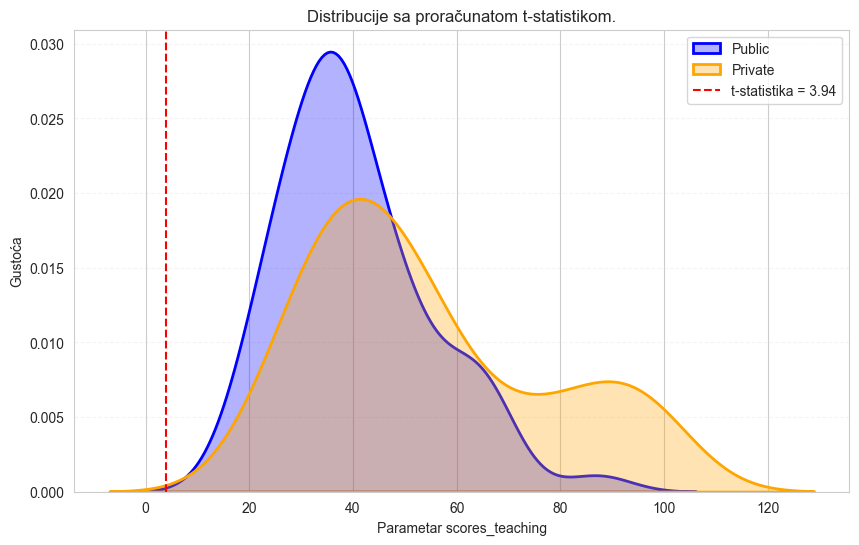

t-statistika: 3.94
p-vrijednost: 0.000
Snaga testa: 98.9%


In [96]:


usa_t_stat, usa_p_value = ttest_ind(usa_private, usa_public, alternative='greater', equal_var=False)

mean_usa_public, mean_usa_private = np.mean(usa_public), np.mean(usa_private)
std_usa_public, std_usa_private = np.std(usa_public, ddof=1), np.std(usa_private, ddof=1)
n_usa_public, n_usa_private = len(usa_public), len(usa_private)

usa_pooled_std = np.sqrt(((n_usa_public - 1) * std_usa_public**2 + (n_usa_private - 1) * std_usa_private**2) / (n_usa_public + n_usa_private - 2))
usa_effect_size = (mean_usa_private - mean_usa_public) / usa_pooled_std

usa_power = TTestIndPower().power(effect_size=usa_effect_size, nobs1=n_usa_private, alpha=0.05, ratio=n_usa_private/n_usa_public, alternative='larger')

plt.figure(figsize=(10, 6))
sns.kdeplot(usa_public, color='blue', label='Public', fill=True, alpha=0.3, linewidth=2)
sns.kdeplot(usa_private, color='orange', label='Private', fill=True, alpha=0.3, linewidth=2)
plt.axvline(usa_t_stat, color='red', linestyle='--', label=f't-statistika = {usa_t_stat:.2f}')
plt.xlabel('Parametar scores_teaching')
plt.ylabel('Gustoća')
plt.title('Distribucije sa proračunatom t-statistikom.')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.show()

print(f"t-statistika: {usa_t_stat:.2f}")
print(f"p-vrijednost: {usa_p_value:.3f}")
print(f"Snaga testa: {usa_power:.1%}")

I na kraju dolazimo do najubjedljivijeg zaključka ove zadaće.  
Sa P-vrijednosti od 0.000, i snagom testa 98.9%, uočavamo sljedeći **statistički ubjedljiv zaključak**:
> Na osnovu ovog dokaza **opovrgavnemo hipotezu H0** (Državni i privatni univerziteti u SAD-u imaju isti prosječni rezultat za nastavni proces)   
> **u korist hipoteze H1: Privatni univerziteti u SAD-u imaju prosječno bolje rezultate za nastavni proces od privatnih.**

Zbog ovoga smo nagovještavali da status privatnih univerziteta itekako zavisi od jednog uređenja do drugog, te zbog toga nismo uspjeli pronaći velika odstupanja na svjetskom nivou.  

No, činjenica da velik procenat privatih univerziteta iz ovog uzorka su upravo iz SAD-a **nedvosmisleno utiče na reprezentativnost ovog uzorka prilikom posmatranja populacije šire od te države,** što je jedan od neformalnih dokaza prve postavljene alternativne hipoteze.

---

### 2.4. **Hipoteza:** Međunarodna povezanost Univerziteta u Sarajevu je značajno ispod evropskog prosjeka 

Član tima: **Tarik Redžić**

---

## **Linearni regresivni model seta podataka**

Predstavlja: **Aid Mustafić**

U ovom poglavlju, pokušati ćemo istrenirati linearni regresivni model predikcije rezultata rangiranja, *'scores_overall_rank'*, odnosno odgovoriti na pitanje: 
> *Da li postoji način da na osnovu kriterija rangiranja, dobijemo ranking nekog proizvoljnog univerziteta?*

#### 3.1 **Postavka i priprema podataka**


> * **Odgovor (target)**: _'scores_overall_rank'_
> * **Regresori (features)**: 
    'scores_teaching_rank',
    'scores_research_rank',
    'scores_citations_rank',
    'scores_industry_income_rank',
    'scores_international_outlook_rank'

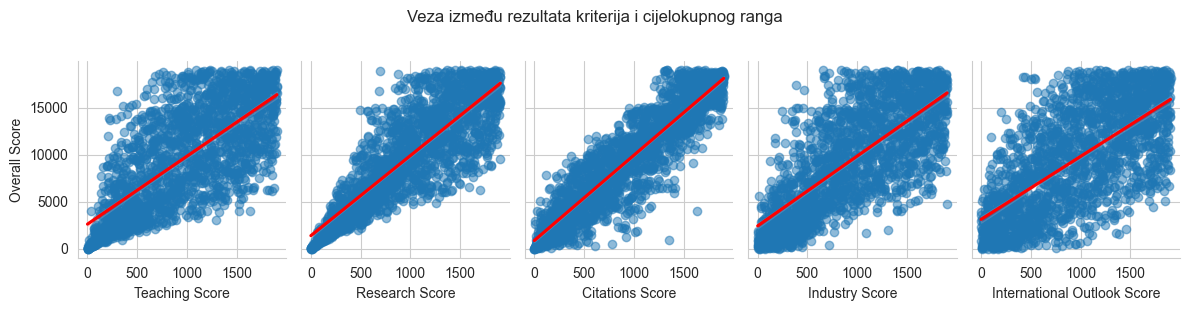

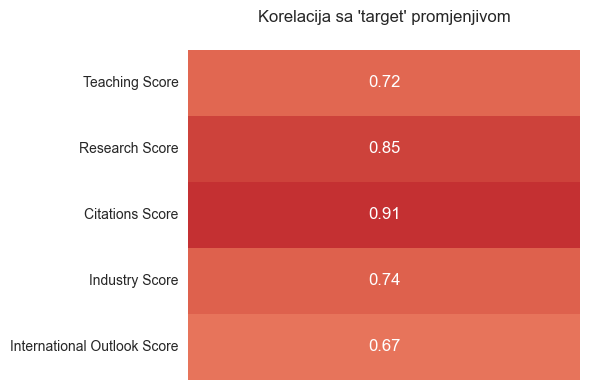

In [ ]:
column_rename = {
    'scores_teaching_rank': 'Teaching Score',
    'scores_research_rank': 'Research Score',
    'scores_citations_rank': 'Citations Score',
    'scores_industry_income_rank': 'Industry Score',
    'scores_international_outlook_rank': 'International Outlook Score',
    'scores_overall_rank': 'Overall Score'
}

df_model = df_ranked.rename(columns=column_rename,inplace=False)

features = [
    'Teaching Score', 
    'Research Score', 
    'Citations Score',
    'Industry Score',
    'International Outlook Score',
]
target = 'Overall Score'
plot = sns.pairplot(
    data=df_model[features+[target]],
    x_vars=features,
    y_vars=['Overall Score'],  # Prikaži samo veze sa target-om
    height=3,
    aspect=0.8,
    kind='reg',  # Dodaje liniju regresije
    plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.5}}
)
x = df_model[features]
y= df_model[target]
plt.suptitle('Veza između rezultata kriterija i cijelokupnog ranga', y=1.02)
plt.tight_layout()
plt.show()

correlation_matrix = df_model[features+ [target]].corr()

overall_corr = correlation_matrix[[target]].drop(target)

plt.figure(figsize=(6, 4))
sns.heatmap(overall_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={'size': 12}, cbar=False)

plt.title('Korelacija sa \'target\' promjenjivom', pad=20)
plt.xticks([]) 
plt.yticks(rotation=0) 
plt.tight_layout()
plt.show()

Sa prethodne vizualizacije, uočavamo gotovo linearnu zavisnost sa različitim stepenima varijanse i nagiba, što nam ide u korist.  
Uočavamo još da *feature* sa najočitijom pozitivnom korelacijom je **'scores_citations_rank'** (rank po istraživačkom citiranju) sa 0.91.

U svrhu treniranja modela, podijeliti ćemo podatke na _train_ i _test_, gdje se 80% podataka koristi isključivo za treniranja, a preostalih 20% za testiranje validnosti istog.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


X_train, X_test, y_train, y_test = train_test_split(
    df_model[features], df_model[target], 
    test_size=0.2, 
    random_state=42 
)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f"MSE: {mse:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")
coefficients = pd.Series(model.coef_, index=features).sort_values(ascending=False).to_frame(name='Koeficijent u modelu')
display(coefficients)


Training set: (1523, 5), Test set: (381, 5)
MSE: 1763647.01
R² Score: 0.94


,Koeficijent u modelu
Citations Score,5.59
Teaching Score,2.15
Research Score,1.99
International Outlook Score,1.11
Industry Score,0.60


<h5><i>Set podataka za treniranje se sastojao od 1523 reda, dok set podataka za validaciju od 381 reda.</h5></i>

Sada razmotrimo prethodne skalarne vrijednosti koje okarakterišu naš istrenirani model:
* **Koeficijenti modela**: _Koliko koji podatak utiče na rezultat?_  
    * Kao što je očekivano, model je istreniran da **najviše cijeni rezultate istraživačkog citiranja**, dok **industrijski rezultati** skoro pa **nikakvu ulogu ne igraju.** 
* **R^2 podatak**: Koliku varijabilnost u setu podataka naš model dostiže / može opisati?
    * Dobili smo da je to 0.94, dakle **čak 94% ovog seta podataka je moguće objasniti i dostići ovim modelom.**
* **MSE (Mean Squared Error)**: Naša _loss funkcija_. Kolika je srednja kvadrirana razlika, tj. _greška_ pravog zapisa i predikcije. (Shvati kao neku vrstu varijanse.)
    * Dobili smo  176364,701, što je kvadrat od 132,8. Dakle, srednja greška je za 130 mjesta. Ovo se jednostavno može pripisati nedostatku šuma i arbriratnih kriterija koje nisu čak ni dio seta podataka, već same rang liste. Sa ovim također možemo biti vrlo zadovoljni.


I konačno, da vidimo kako to sve izgleda vizuelno. Uporediti ćemo stvarne dodijeljene i predviđene rangove, te ćemo uključiti i vizualizaciju za 100% tačno predviđanje, čišto radi perspektive.

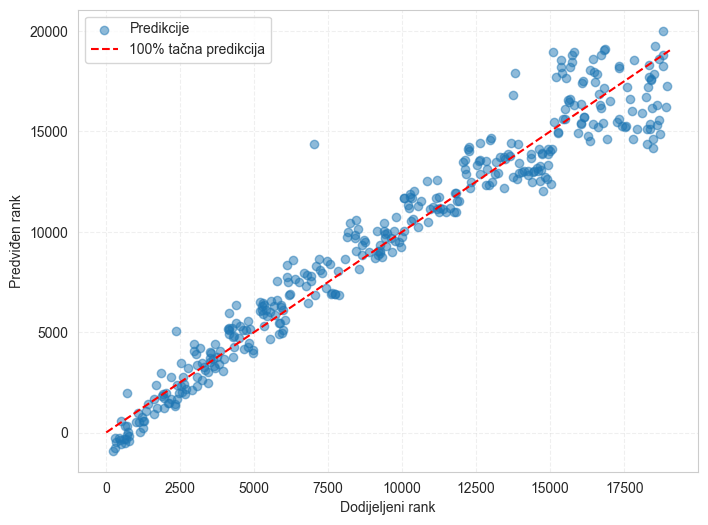

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predikcije')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='100% tačna predikcija')
plt.xlabel('Dodijeljeni rank')
plt.ylabel('Predviđen rank')
plt.title('')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


---

#### Kao interesantan primjer, napravimo predikciju koristeći rezultate kriterija Univerziteta u Sarajevu i uporediti sa pravim dodjeljenim rangom na listi.

Recimo, da iz **Univerziteta u [Buturović Polju](https://maps.app.goo.gl/8gKU3ofwi4Fqr2Ax9) (UniBP)**, kao nerangirani, smatraju da su pokradeni.  
Po zvaničnim kriterijima su isti kao rangirani Univerzitet u Sarajevu, ali neke nepravilnosti su utjecale na konačni ishod.  
> Kada bi našim modelom istreniranim po isključivo tim kriterijima, gdje bi Univerzitet u Buturović Polju trebao biti rangiran?

In [34]:
display(df_model[df_model['Overall Score'] == 18290][['name'] + features ])
UniBP = pd.DataFrame([{
    'Teaching Score':1673,
    'Research Score':1552,
    'Citations Score':1707,
    'Industry Score':1379,
    'International Outlook Score':1593 # Turistička atrakcija od mjesta
}])
predikacija = model.predict(UniBP)
print(f"Univerzitet u Buturović Polju bi bio rangiran na {predikacija[0]/10:.0f}. mjestu!")
print("Na tom mjestu se trenutno nalazi: ")
display(df_model[df_model['Overall Score'] == 17460][['name'] + features ])



,name,Teaching Score,Research Score,Citations Score,Industry Score,International Outlook Score
1828,University of Sarajevo,1673,1552,1707,1379,1593


Univerzitet u Buturović Polju bi bio rangiran na 1746. mjestu!
Na tom mjestu se trenutno nalazi: 


,name,Teaching Score,Research Score,Citations Score,Industry Score,International Outlook Score
1745,National University of Córdoba,1551,1614,1677,1567,1235


Model prognozira da bi _UniBP_ bio čak **82 mjesta iznad UNSA**, što nije neobično. Kao što smo naveli na samom početku, mnoge stvari ulaze u sami kriterij ocjenjivanja, kao i neke arbitrarne, ali neizostavne stavke, poput reputacije univerziteta.

Dok model jeste po tom pitanju ograničen, i sa svojim ograničenjem predstavlja veoma pouzdano rješenje.  
Predviđamo da upotreba ovakvog modela bi bila korisna **maturantima srednjih škola pri pravom odabiru univerziteta**, višem nastavnom osoblju **pri razmatranju budućih unapređenja** ili generalno za **ispitivanje pristrasnosti ili utjecaje reputacije na stvarni rezultat.**

---
_Autori zadaće: Muradbegović A., Mustafić A., Redžić T., Ljutika Z. (2025)_